In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings

warnings.filterwarnings('ignore')

# Updated tickers and date ranges
tickers = [
    'AAPL', 'AIR.PA', 'ALV.DE', 'AMZN', 'ASML.AS', 'BRK-B', 'GOOGL', 'JPM',
    'LIN.DE', 'MC.PA', 'META', 'MSFT', 'NESN.SW', 'NVDA', 'OR.PA',
    'SAP.DE', 'SIE.DE', 'TSLA', 'VOW3.DE', 'V'
]
start_date = '2010-01-01'
end_date = '2025-05-31'
train_end_date = '2024-09-30'
test_start_date = '2024-10-01'

stock_data = {}
all_predictions = {}
evaluation_metrics = {}

print("Downloading historical stock data...")
for ticker in tickers:
    try:
        data = yf.download(ticker, start=start_date, end=end_date)
        if not data.empty:
            stock_data[ticker] = data['Close'].dropna()
            print(f"Successfully downloaded data for {ticker}. Rows: {len(stock_data[ticker])}")
        else:
            print(f"No data downloaded for {ticker}. Skipping.")
    except Exception as e:
        print(f"Error downloading data for {ticker}: {e}")

print("\n--- Data Download Complete ---")
print("\nTraining and evaluating LSTM model for each stock...")

for ticker, df_close in stock_data.items():
    print(f"\nProcessing {ticker}...")
    df_close.index = pd.to_datetime(df_close.index)

    train_data = df_close[df_close.index <= train_end_date]
    test_data = df_close[(df_close.index >= test_start_date) & (df_close.index <= end_date)]

    if train_data.empty or test_data.empty:
        print(f"Skipping {ticker} due to insufficient data.")
        continue

    actual_prices = test_data.copy()

    try:
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_train = scaler.fit_transform(train_data.values.reshape(-1, 1))
        scaled_test = scaler.transform(test_data.values.reshape(-1, 1))

        def create_sequences(data, seq_length):
            X, y = [], []
            for i in range(len(data) - seq_length):
                X.append(data[i:i + seq_length, 0])
                y.append(data[i + seq_length, 0])
            return np.array(X), np.array(y)

        sequence_length = 60
        X_train, y_train = create_sequences(scaled_train, sequence_length)
        X_test, y_test = create_sequences(scaled_test, sequence_length)

        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
        model.add(LSTM(units=50))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')

        model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0)

        lstm_pred_scaled = model.predict(X_test)
        lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

        start_idx = len(test_data) - len(lstm_pred)
        lstm_series = pd.Series(lstm_pred.flatten(), index=test_data.index[start_idx:])

        rmse = np.sqrt(mean_squared_error(test_data.iloc[start_idx:], lstm_pred))
        evaluation_metrics[ticker] = {'RMSE': rmse}
        all_predictions[ticker] = {
            'Actual': actual_prices,
            'Predicted': lstm_series
        }

        print(f"LSTM RMSE for {ticker}: {rmse:.2f}")

    except Exception as e:
        print(f"LSTM failed for {ticker}: {e}")
        evaluation_metrics[ticker] = {'RMSE': float('inf')}
        all_predictions[ticker] = None

print("\n--- Model Training and Evaluation Complete ---")

print("\nGenerating charts...")
for ticker, result in all_predictions.items():
    if result is None:
        print(f"Skipping chart for {ticker} due to model failure.")
        continue

    actual = result['Actual']
    predicted = result['Predicted']

    plt.figure(figsize=(14, 6))
    plt.plot(actual.index, actual, label='Actual Price', linewidth=2)
    plt.plot(predicted.index, predicted, label='LSTM Predicted Price', linestyle='--', linewidth=2)
    plt.title(f'{ticker} - Actual vs LSTM Predicted Prices (2024 Q4 - 2025)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    filename = f'{ticker}_lstm_prediction.png'
    plt.savefig(filename, dpi=300)
    plt.close()
    print(f"Chart saved for {ticker} as {filename}")

print("\n--- All Charts Generated ---")
print("\nSummary of LSTM Model Performance:")
for ticker, metrics in evaluation_metrics.items():
    rmse = metrics['RMSE']
    if rmse != float('inf'):
        print(f"{ticker}: LSTM RMSE = {rmse:.2f}")
    else:
        print(f"{ticker}: LSTM FAILED")


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for AAPL. Rows: 3876


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for AIR.PA. Rows: 3943


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ALV.DE. Rows: 3915


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for AMZN. Rows: 3876


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ASML.AS. Rows: 3944


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for BRK-B. Rows: 3876


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for GOOGL. Rows: 3876


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for JPM. Rows: 3876


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for LIN.DE. Rows: 3915


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for MC.PA. Rows: 3943


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for META. Rows: 3277


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for MSFT. Rows: 3876


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for NESN.SW. Rows: 3873


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for NVDA. Rows: 3876


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for OR.PA. Rows: 3943


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for SAP.DE. Rows: 3915


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for SIE.DE. Rows: 3915


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for TSLA. Rows: 3754


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for VOW3.DE. Rows: 3915


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for V. Rows: 3876

--- Data Download Complete ---

Training and evaluating LSTM model for each stock...

Processing AAPL...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
LSTM RMSE for AAPL: 12.20

Processing AIR.PA...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
LSTM RMSE for AIR.PA: 6.30

Processing ALV.DE...


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
LSTM RMSE for ALV.DE: 6.56

Processing AMZN...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
LSTM RMSE for AMZN: 6.45

Processing ASML.AS...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
LSTM RMSE for ASML.AS: 22.94

Processing BRK-B...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
LSTM RMSE for BRK-B: 26.09

Processing GOOGL...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
LSTM RMSE for GOOGL: 4.67

Processing JPM...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
LSTM RMSE for JPM: 7.60

Processing LIN.DE...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
LSTM RMSE for LIN.DE: 6.98

Processing MC.PA...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
LSTM RMSE for MC.PA: 17.66

Processing META...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
LSTM RMSE for META: 21.69

Processing MSFT...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
LSTM RMSE for MSFT: 10.65

Processing NESN.SW...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
LSTM RMSE for NESN.SW: 1.54

Processing NVDA...
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step
LSTM RMSE for NVDA: 5

Displaying AAPL_lstm_prediction.png


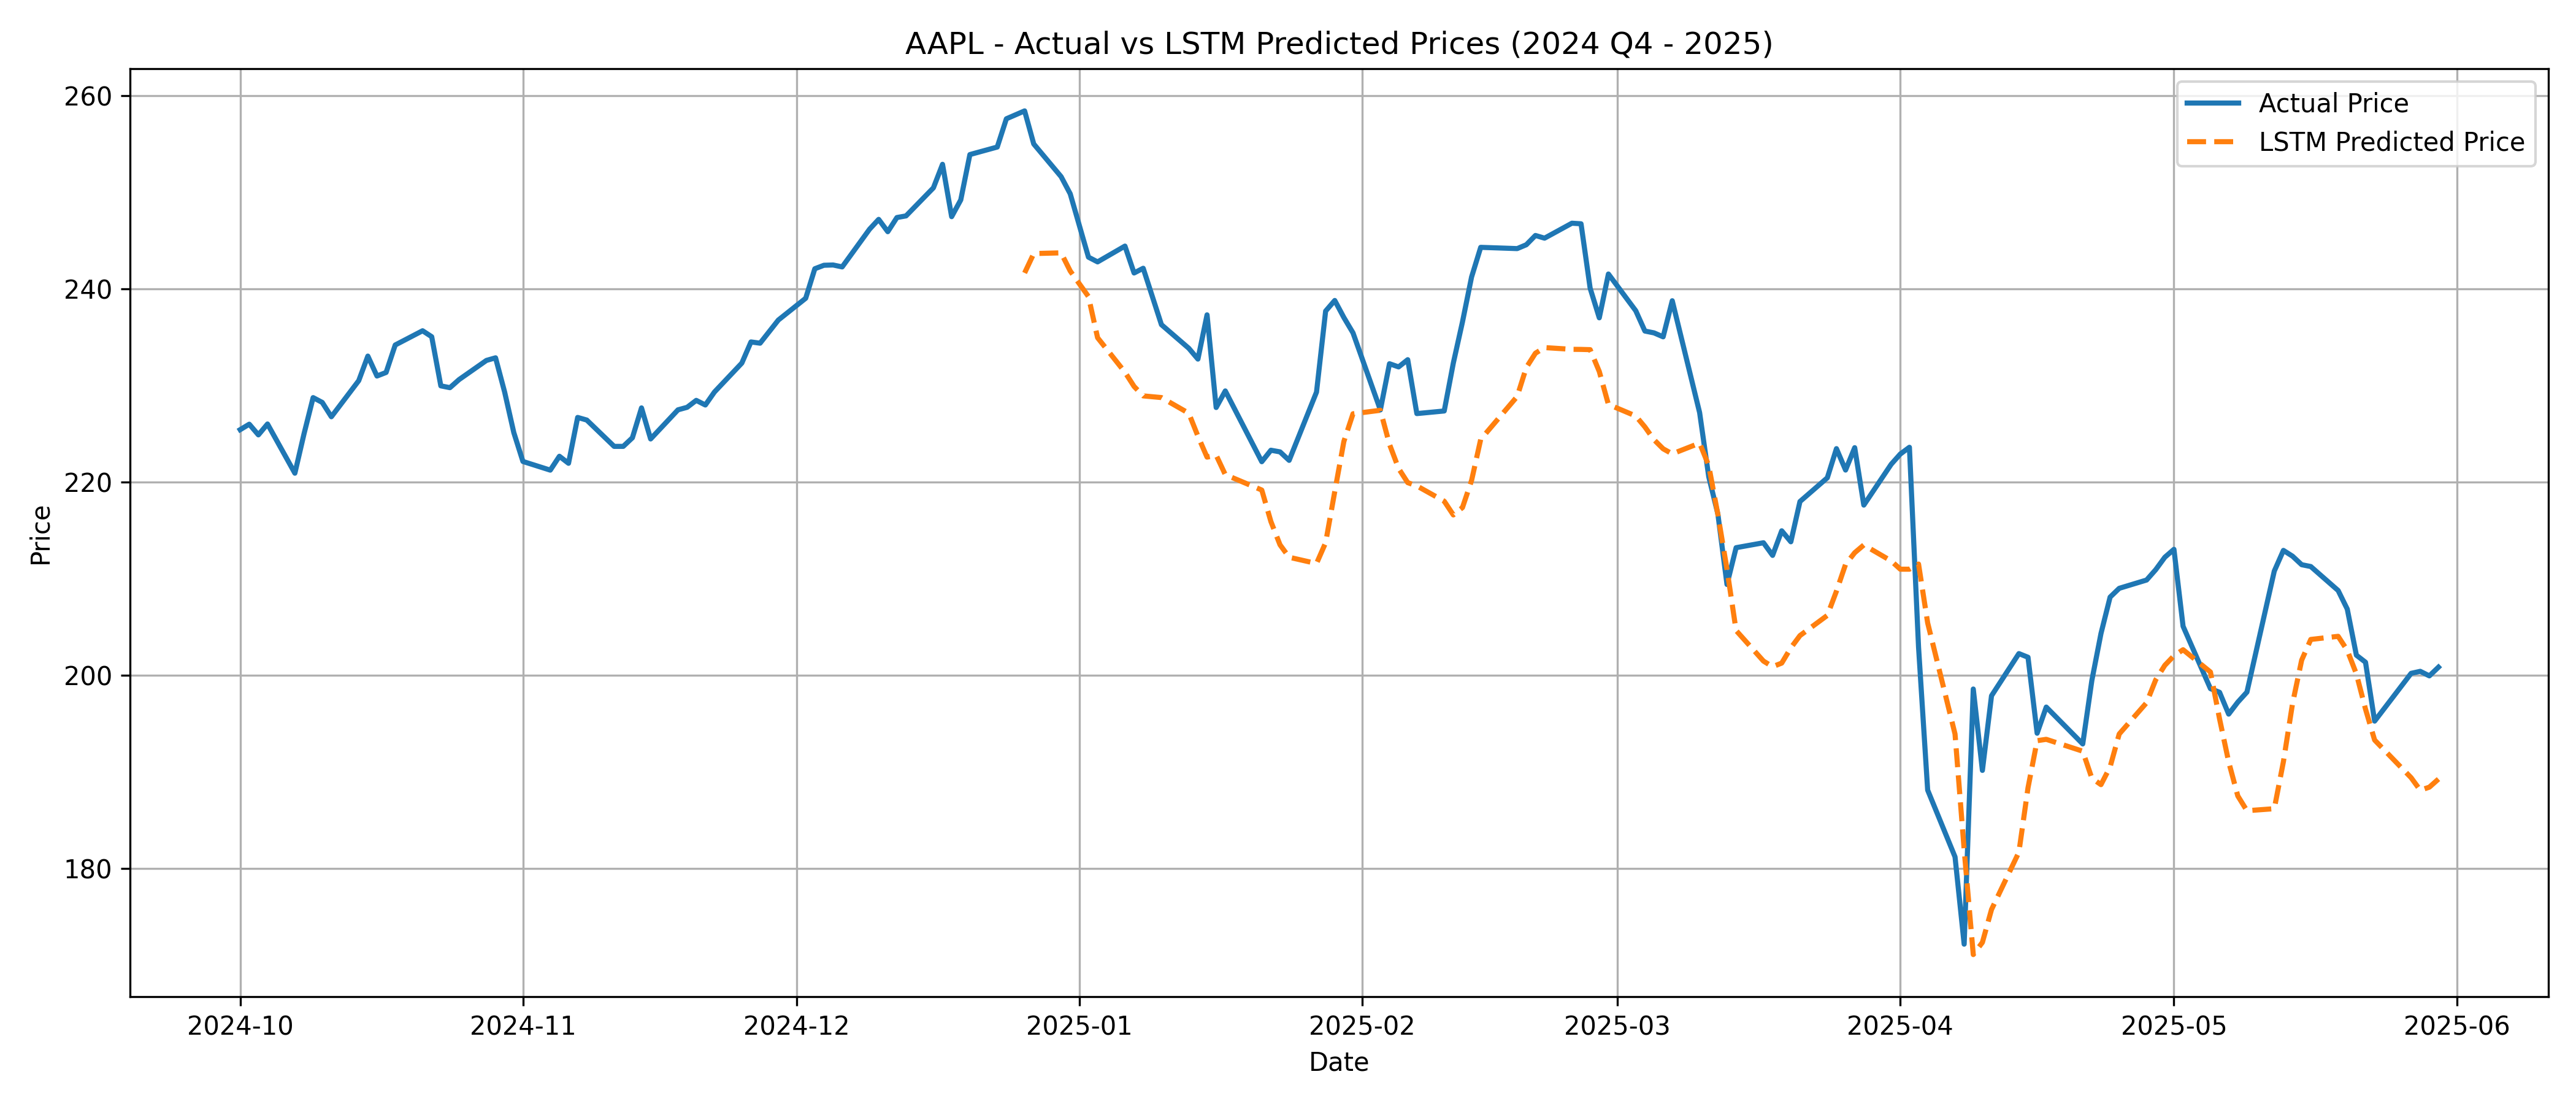

Displaying AIR.PA_lstm_prediction.png


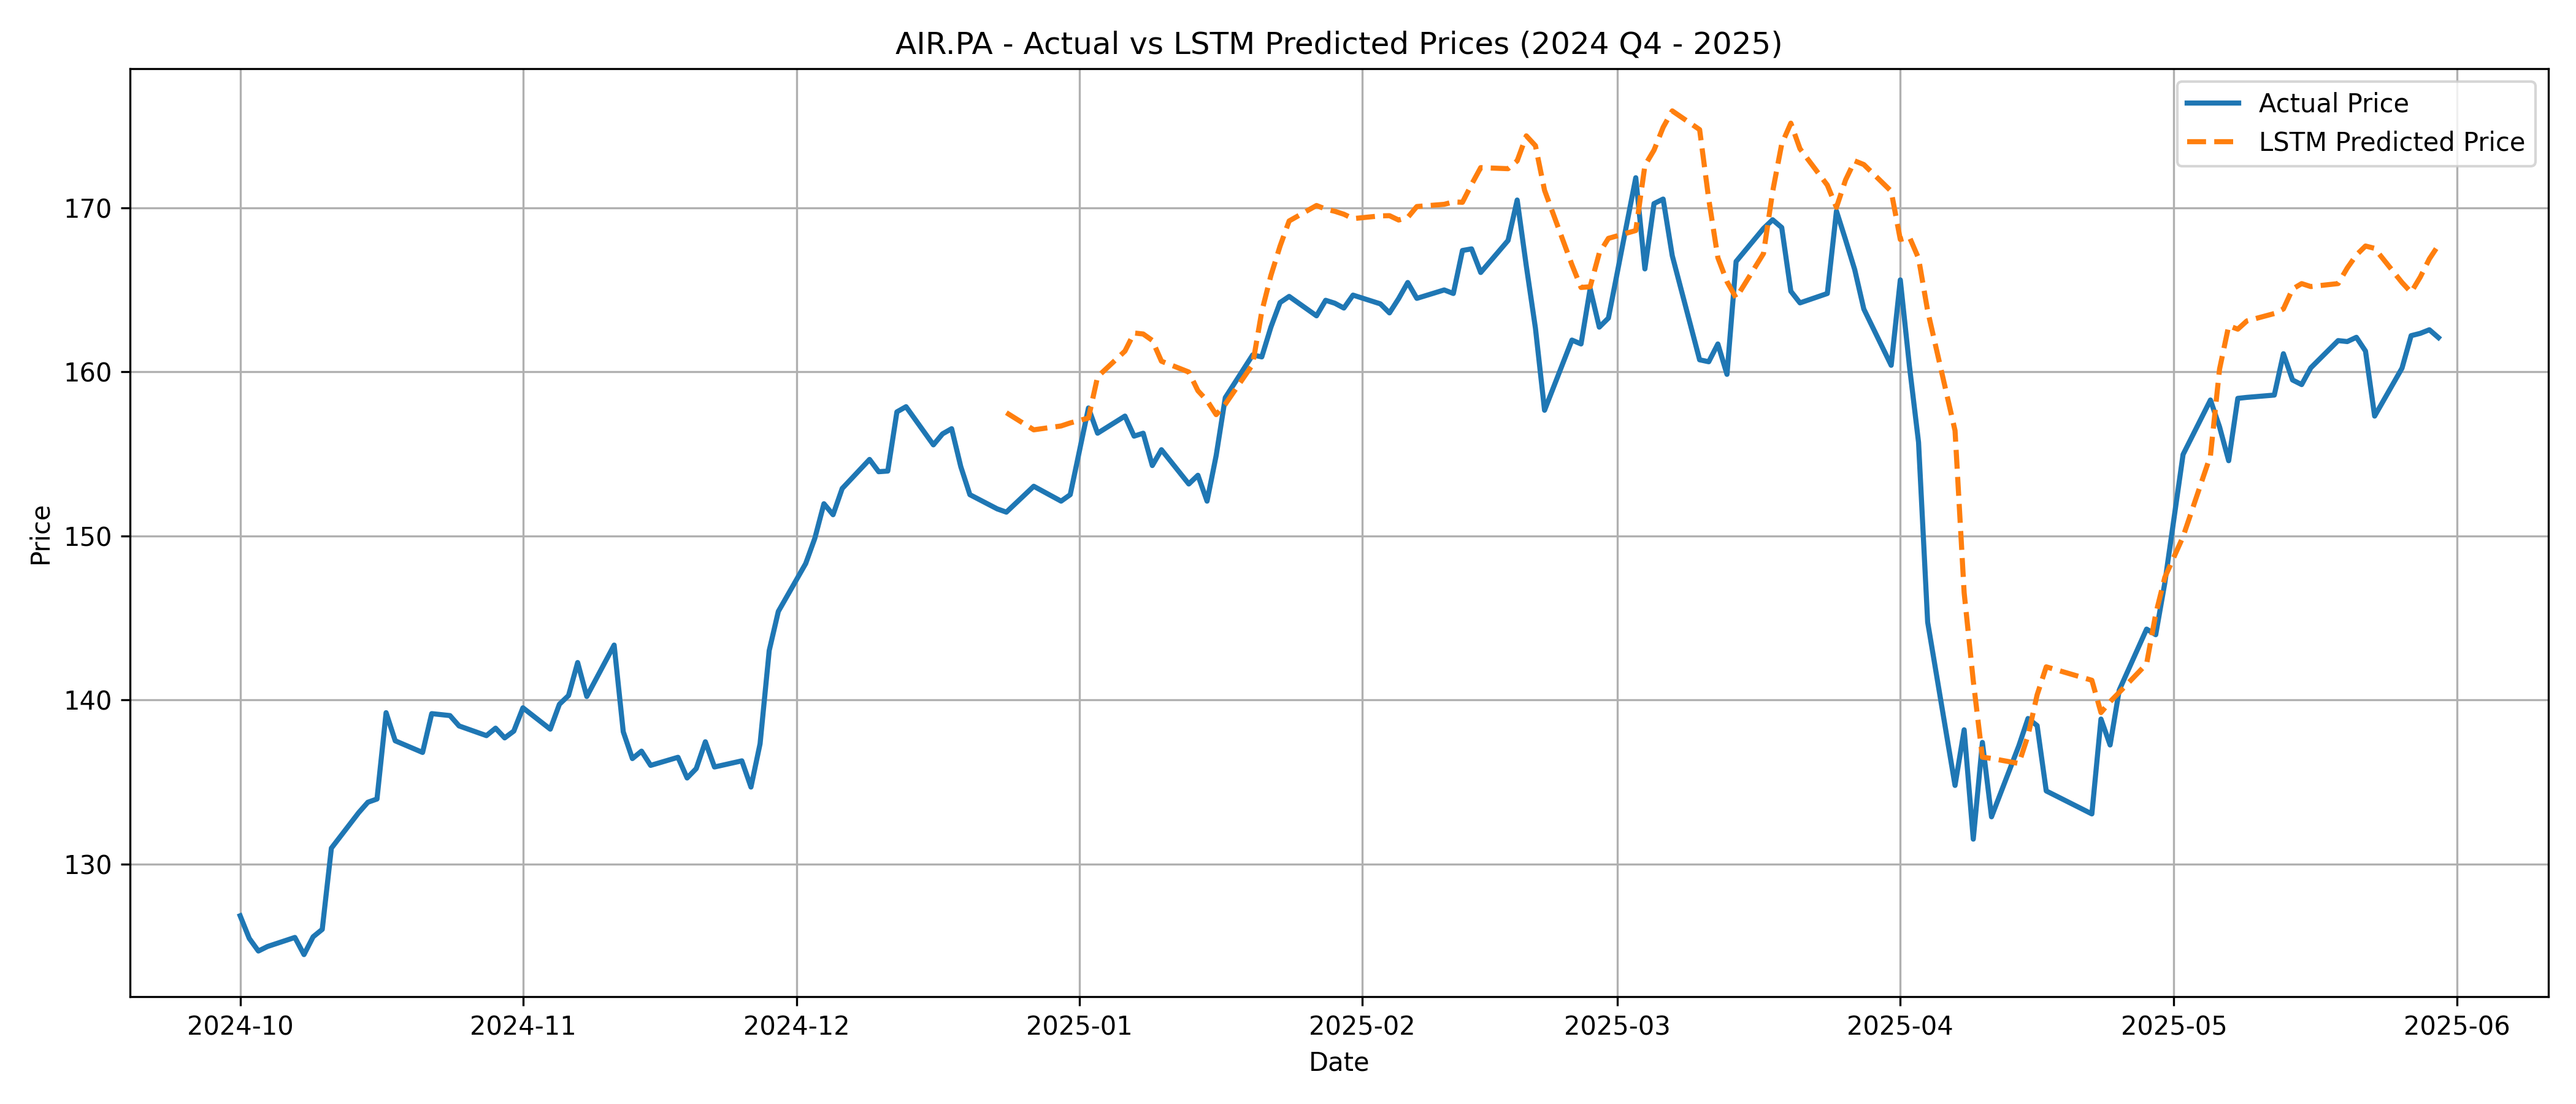

Displaying ALV.DE_lstm_prediction.png


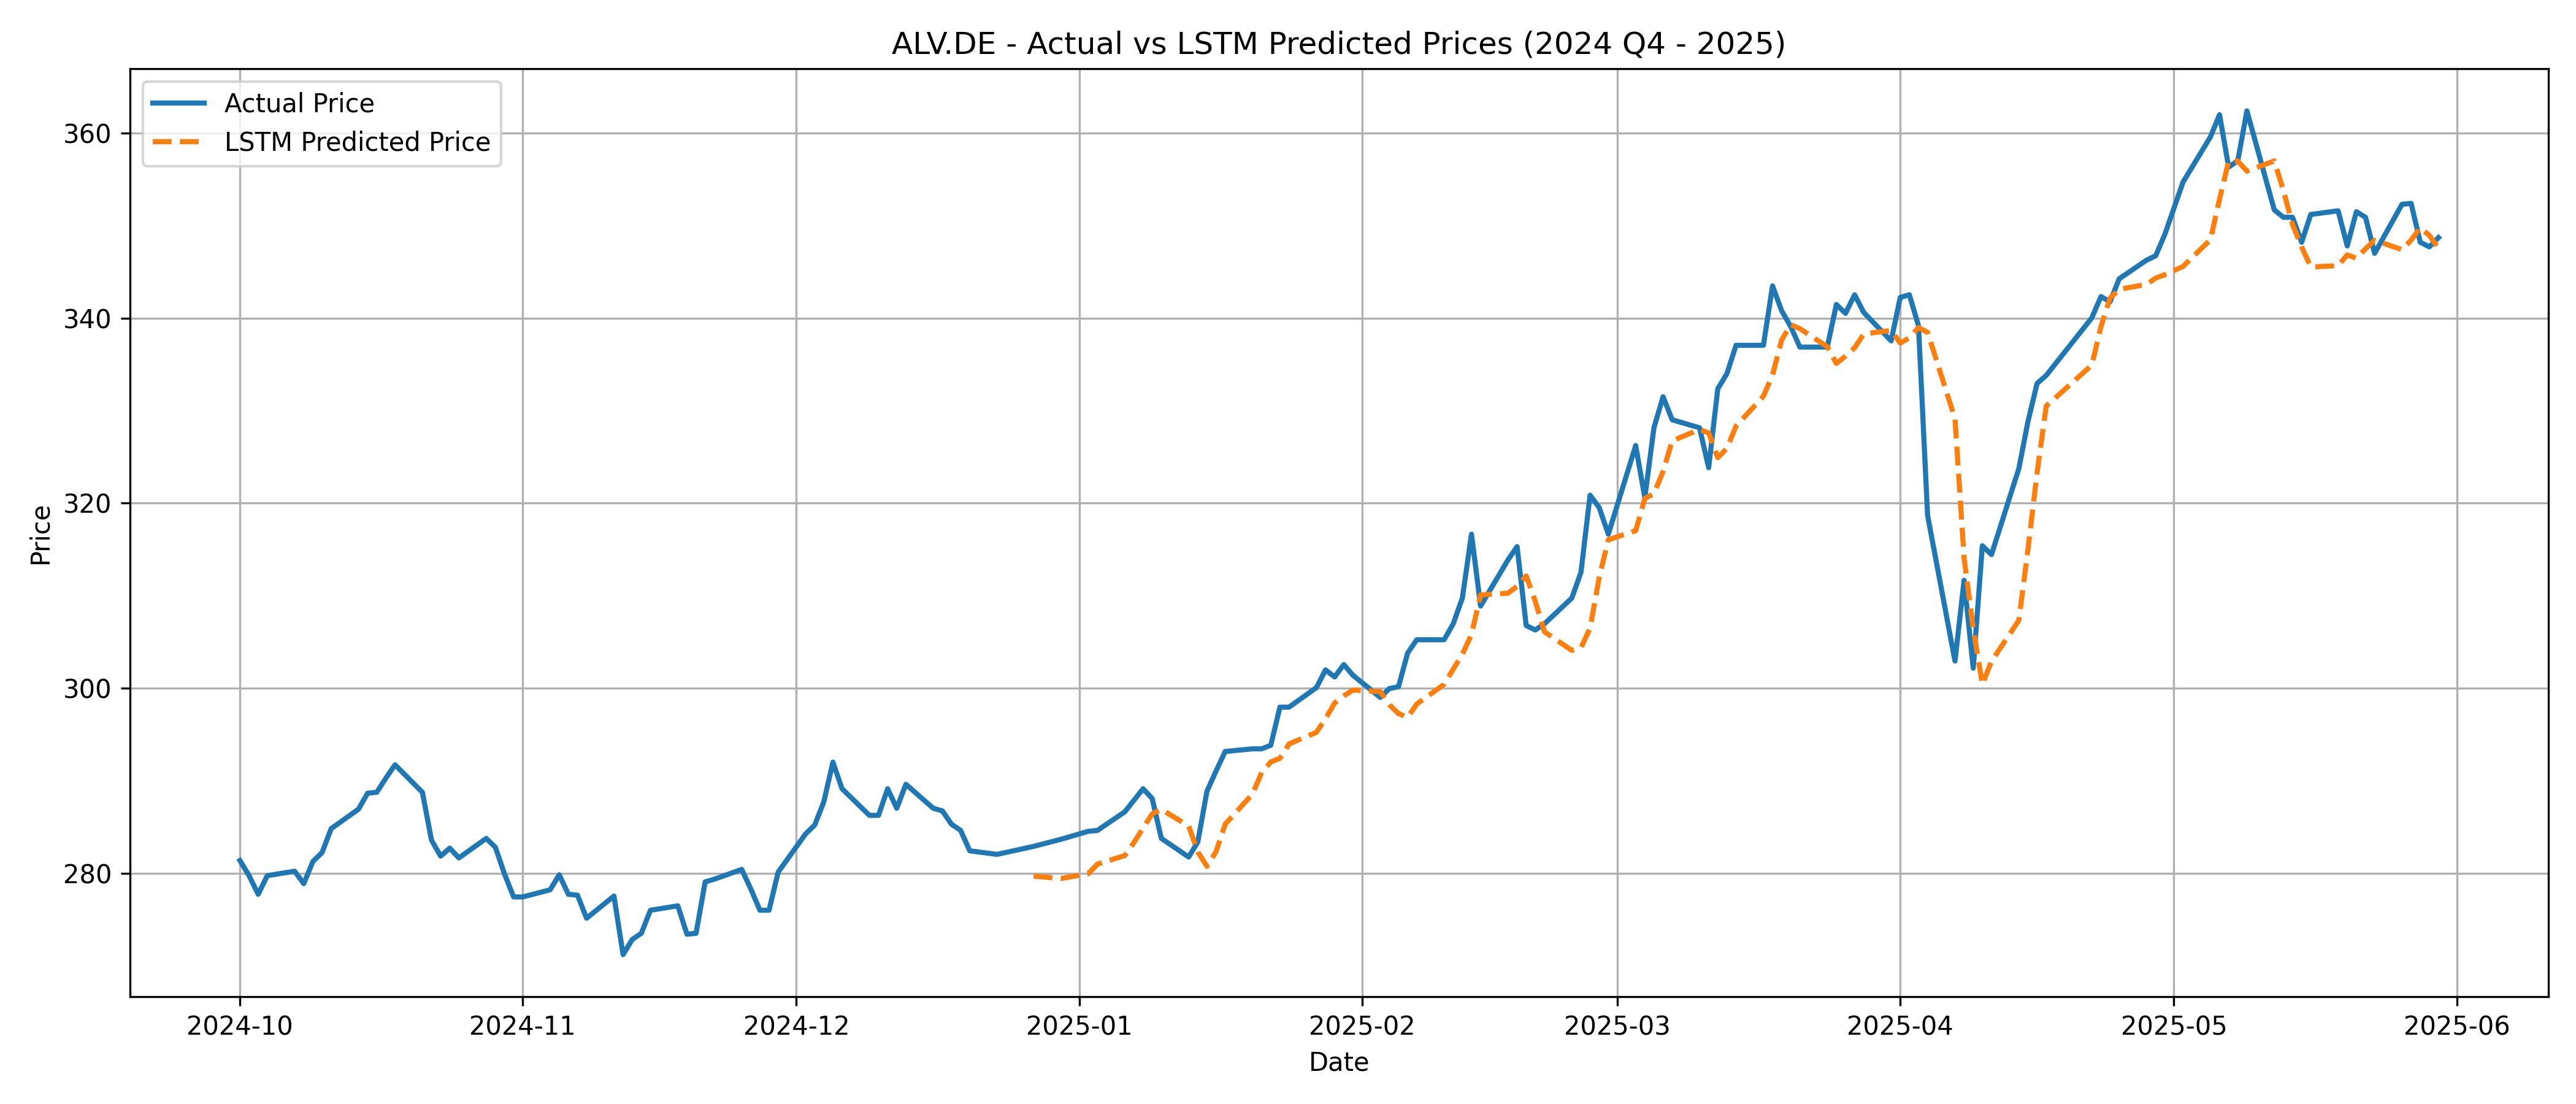

Displaying AMZN_lstm_prediction.png


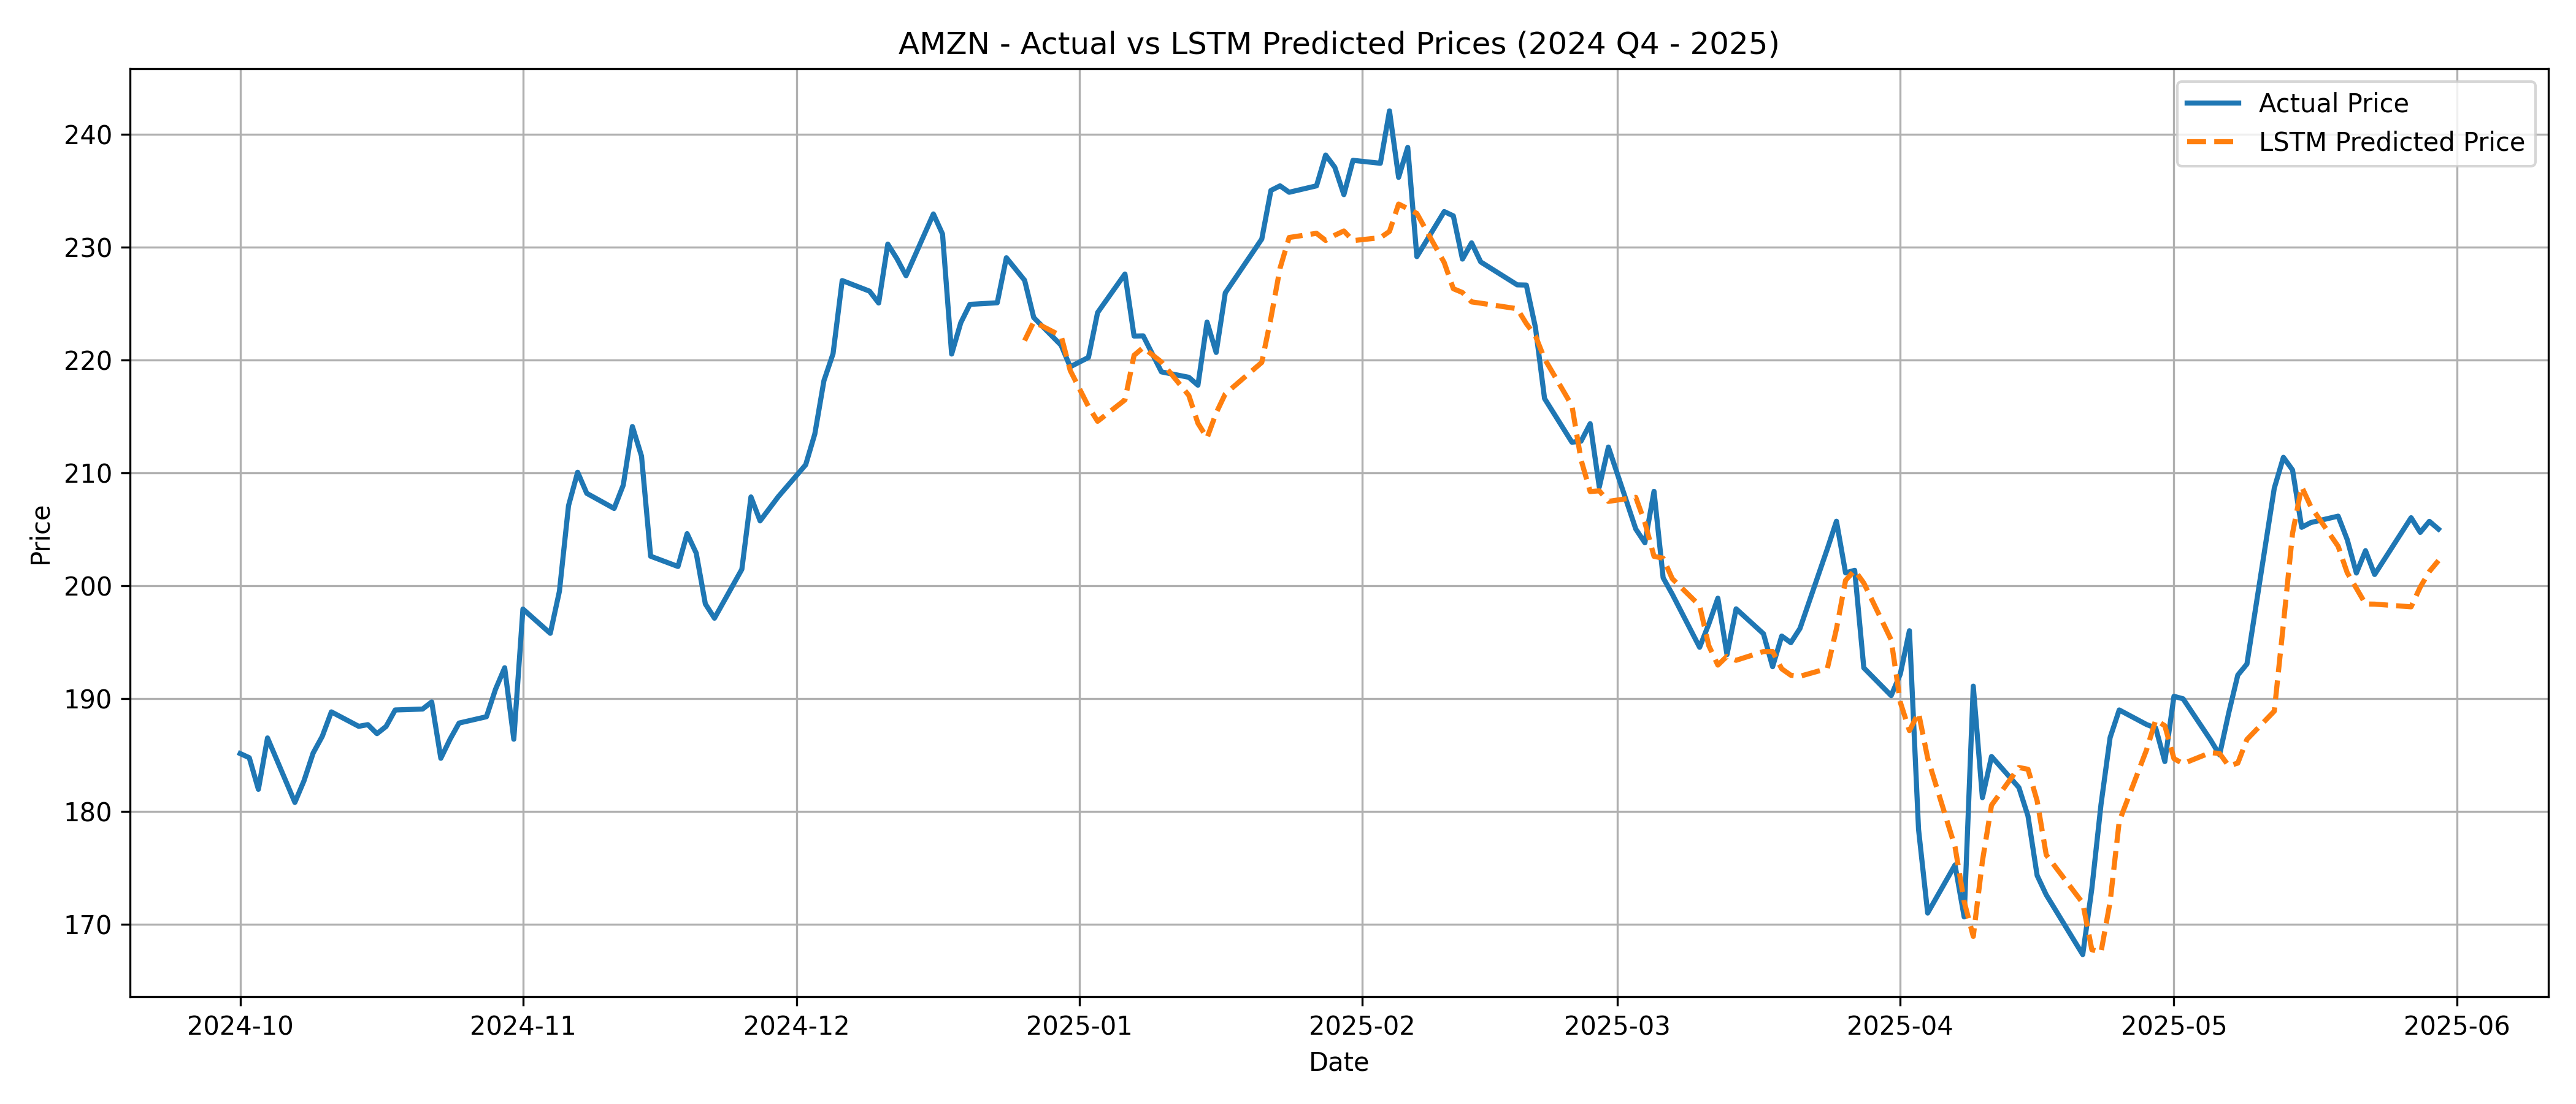

Displaying ASML.AS_lstm_prediction.png


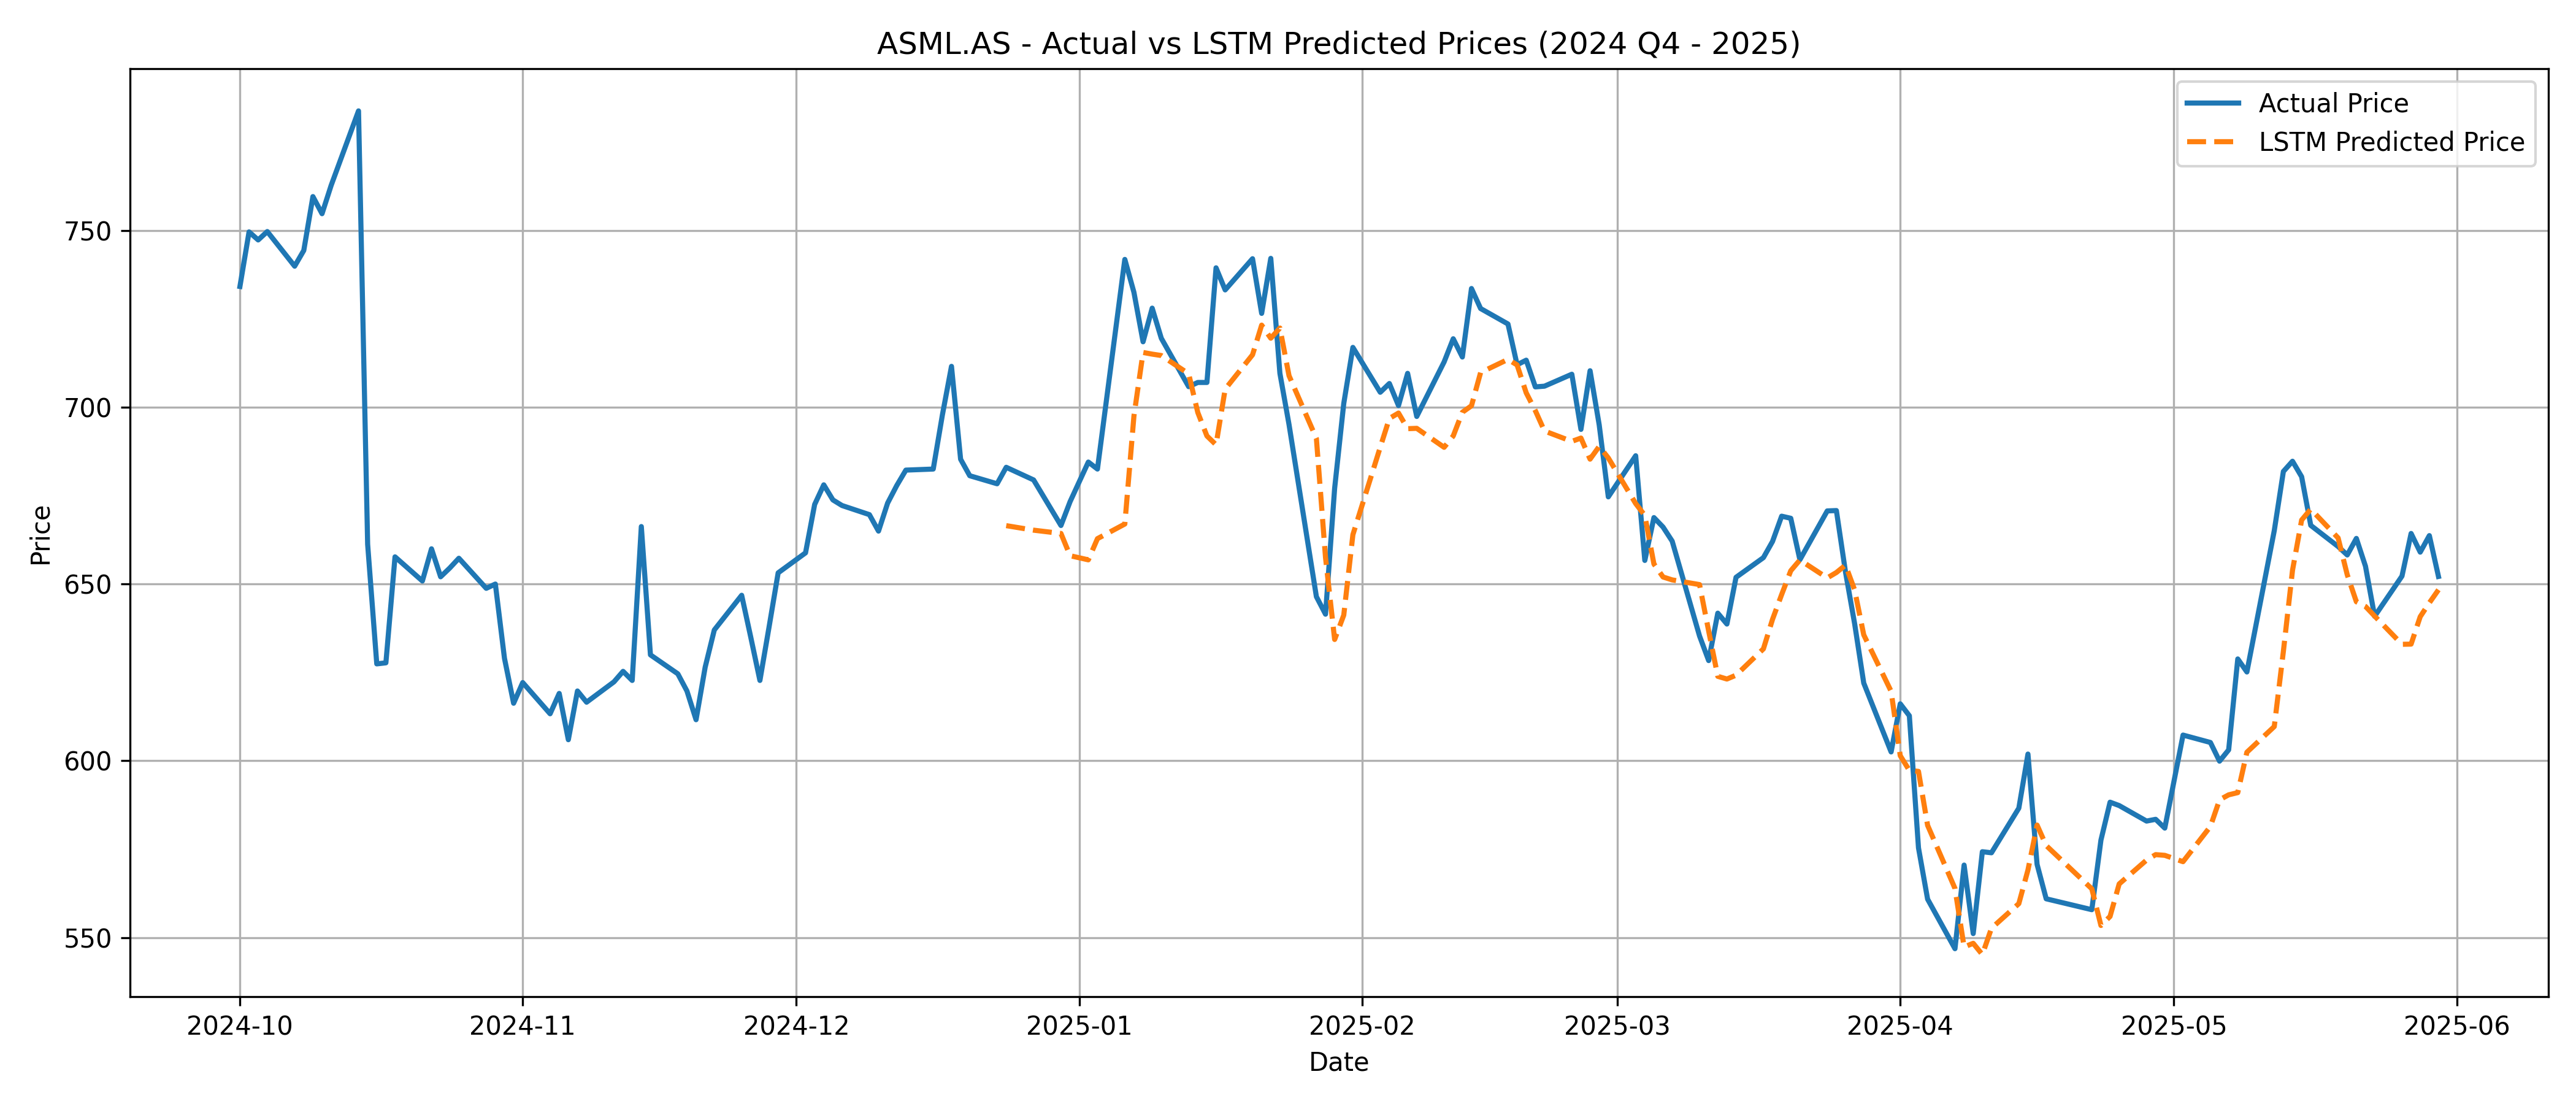

Displaying BRK-B_lstm_prediction.png


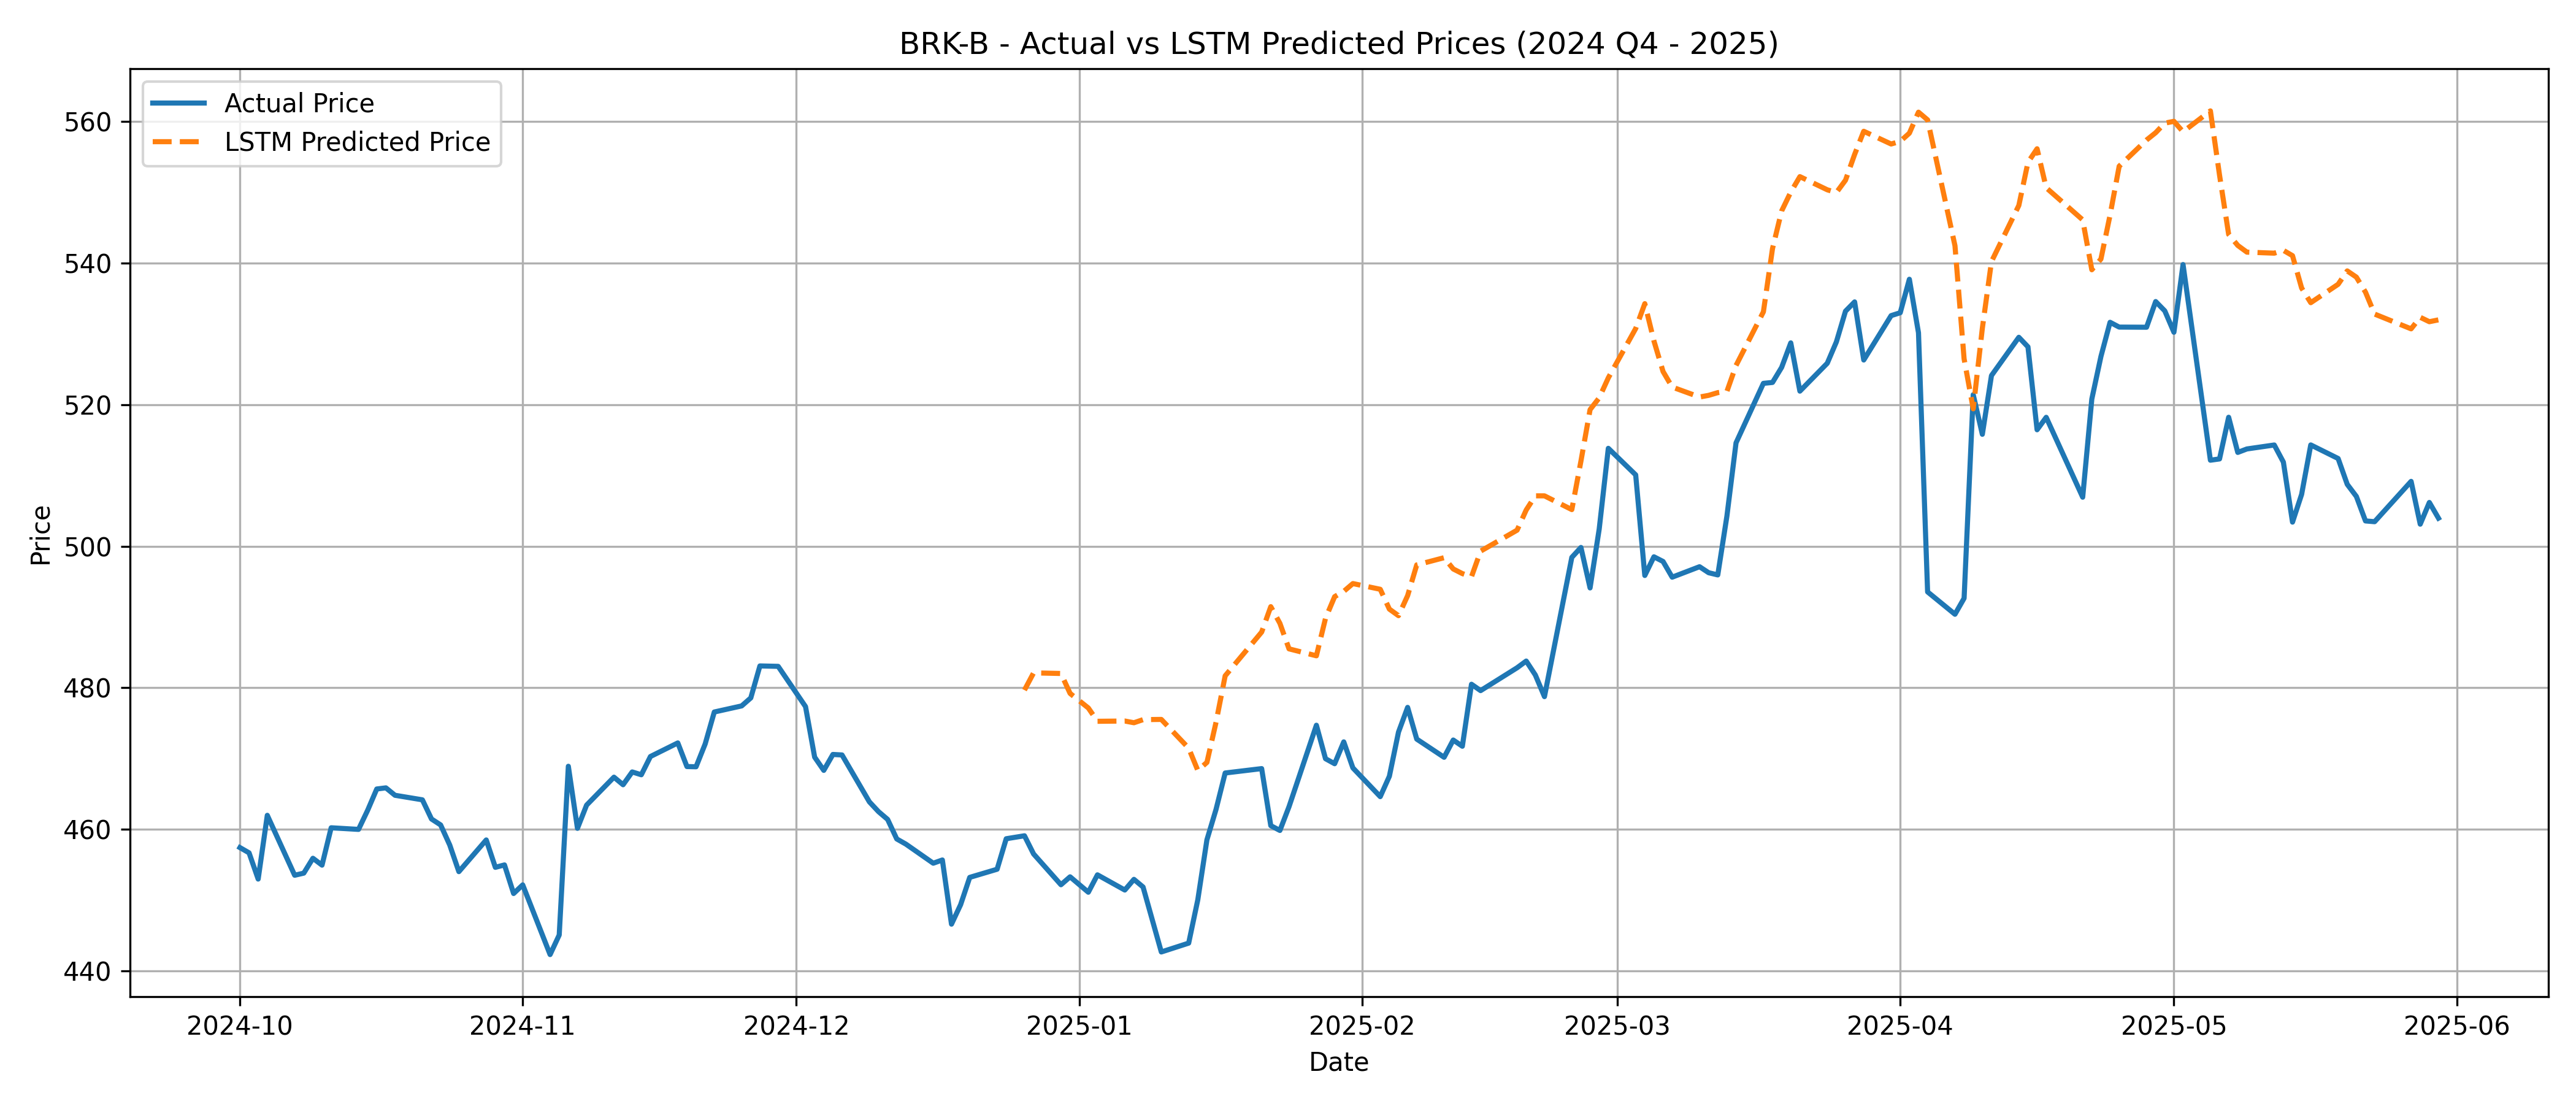

Displaying GOOGL_lstm_prediction.png


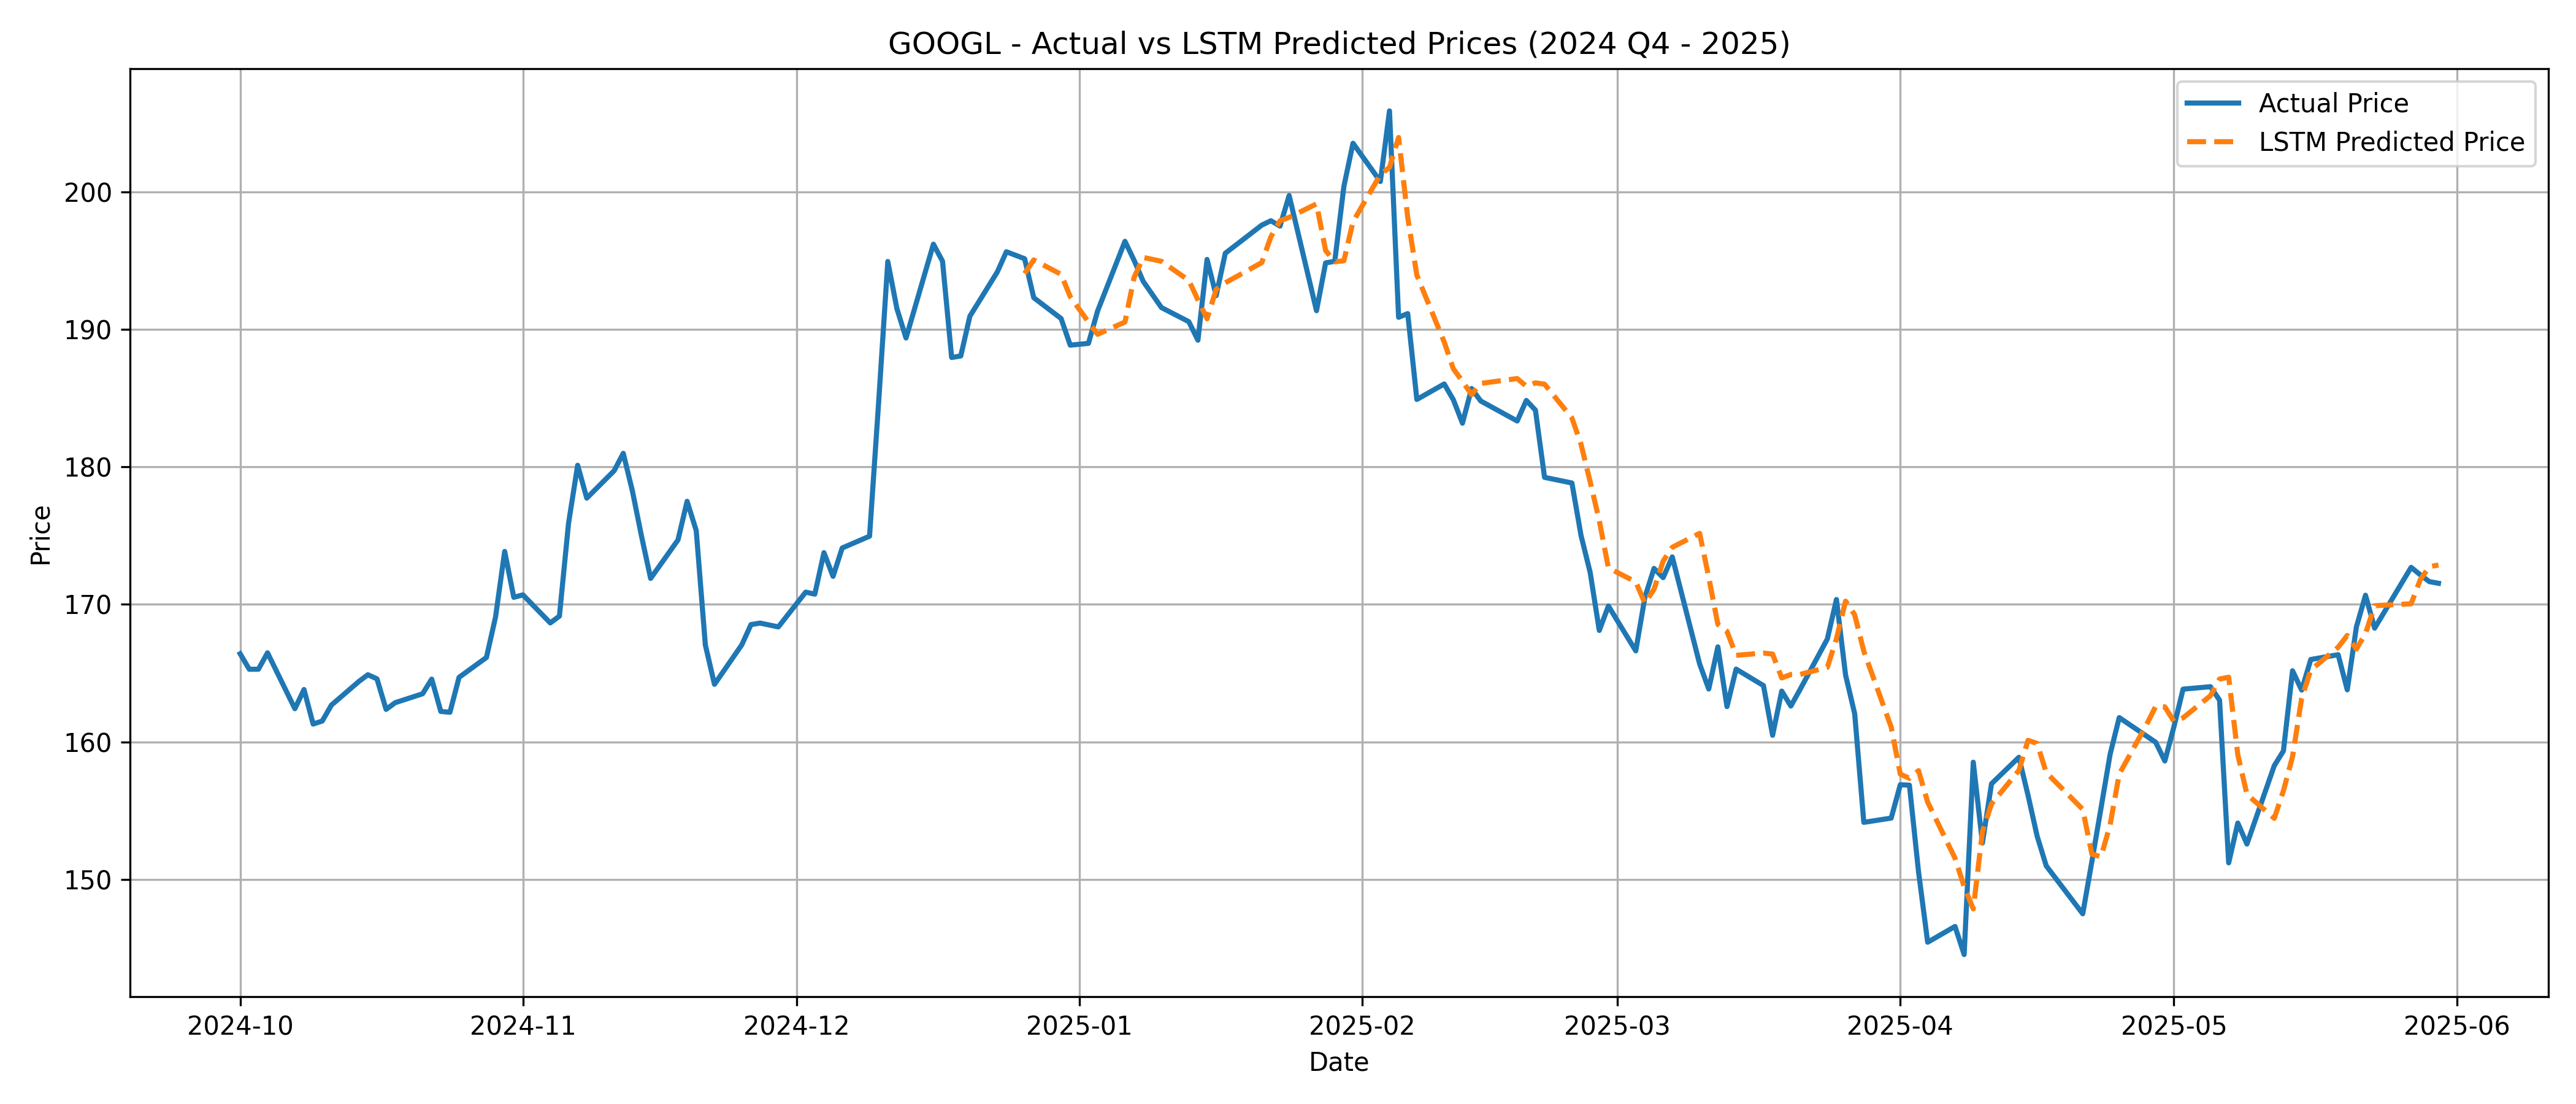

Displaying JPM_lstm_prediction.png


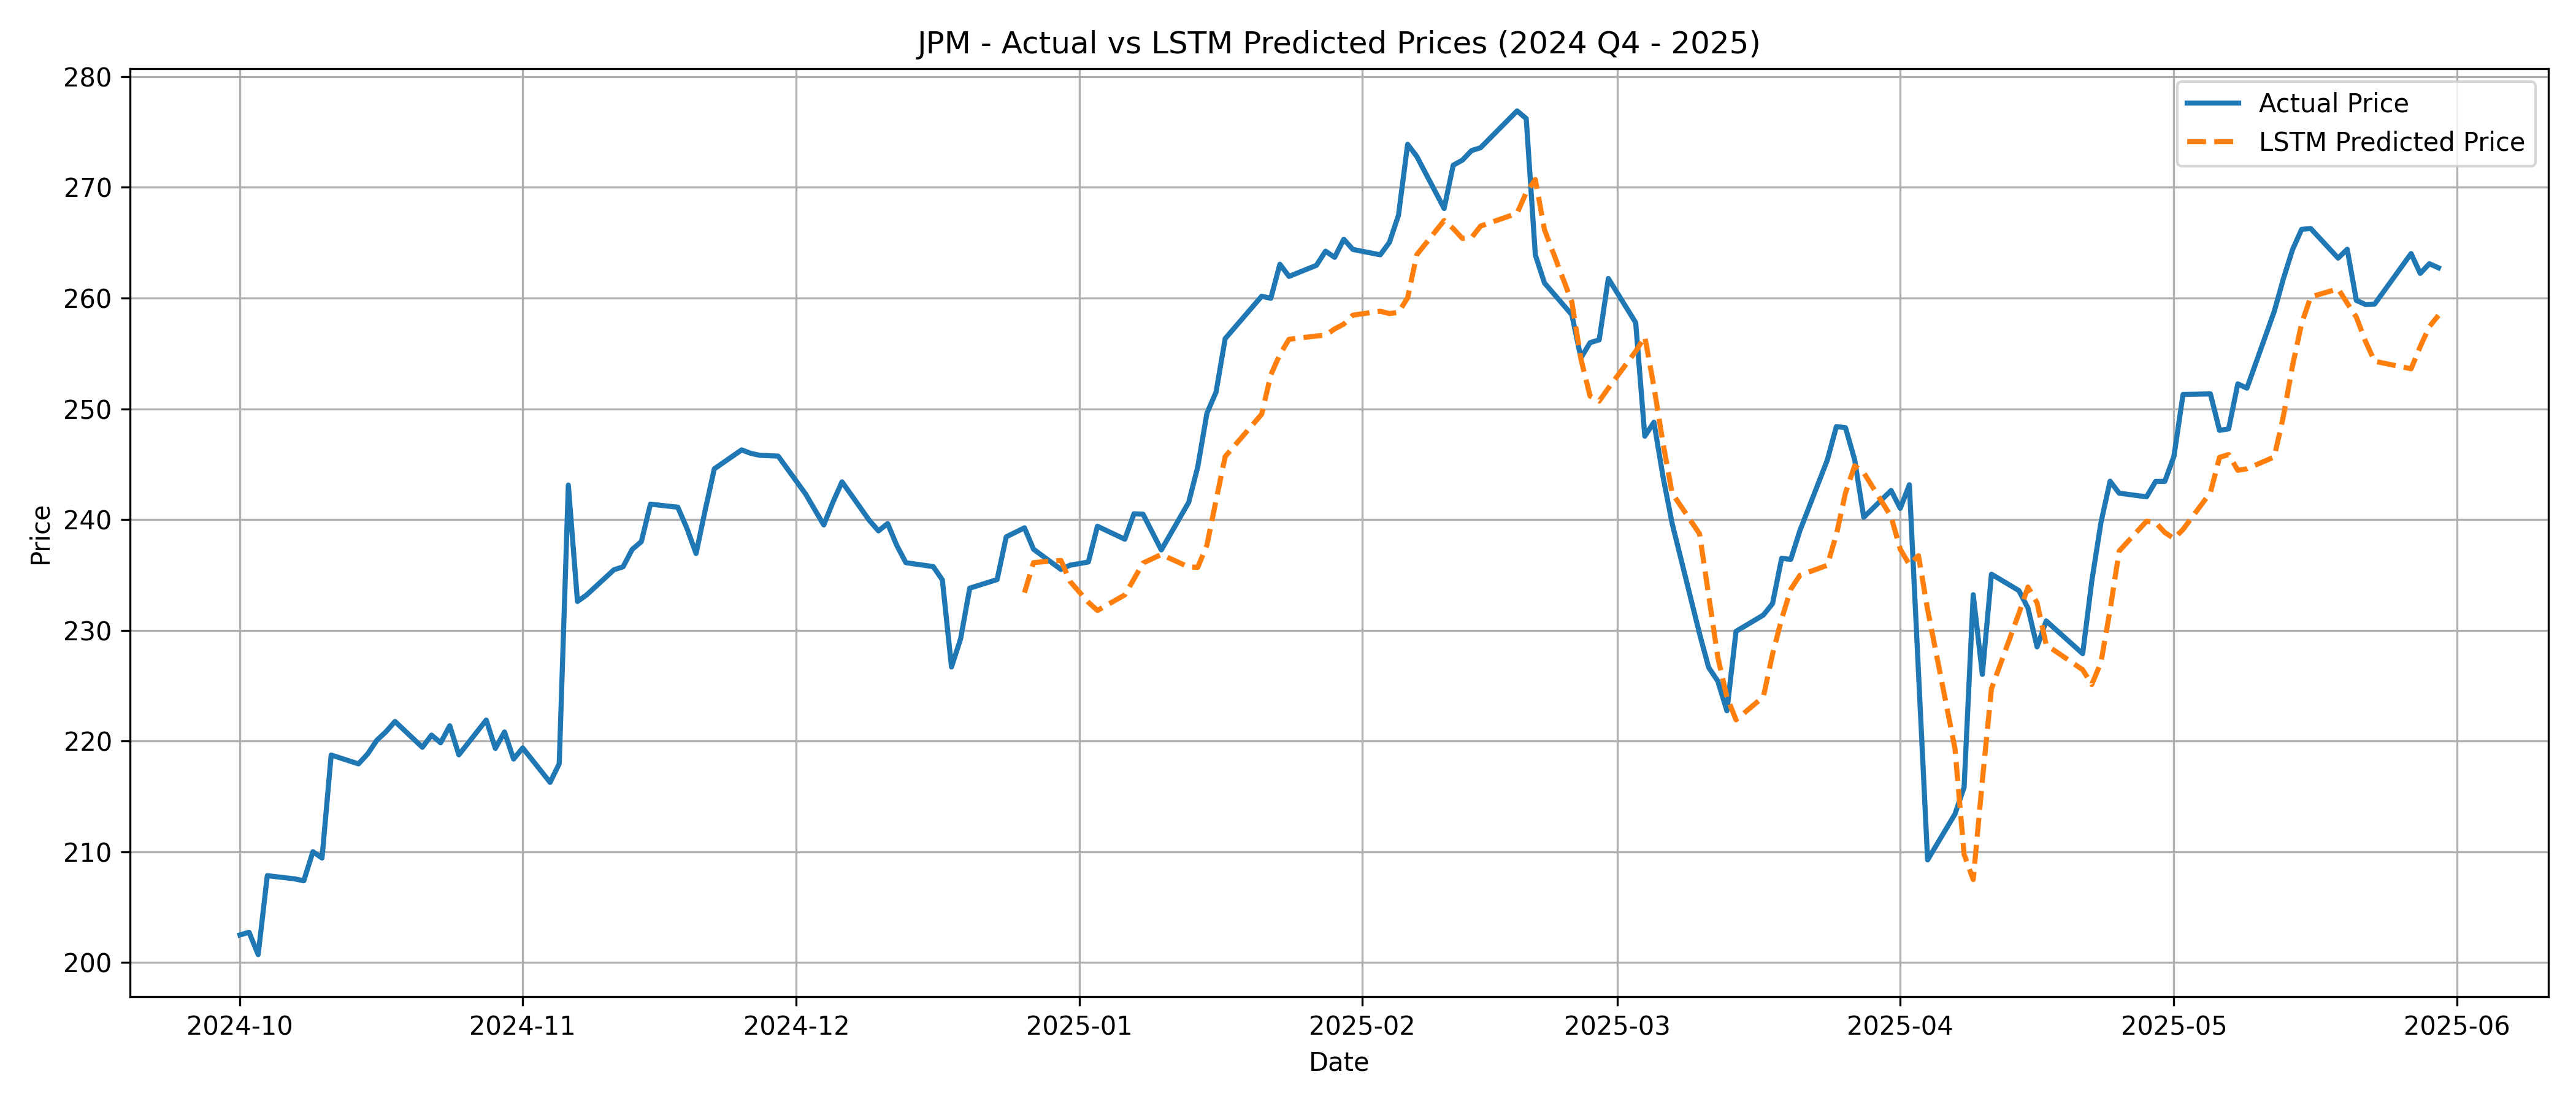

Displaying LIN.DE_lstm_prediction.png


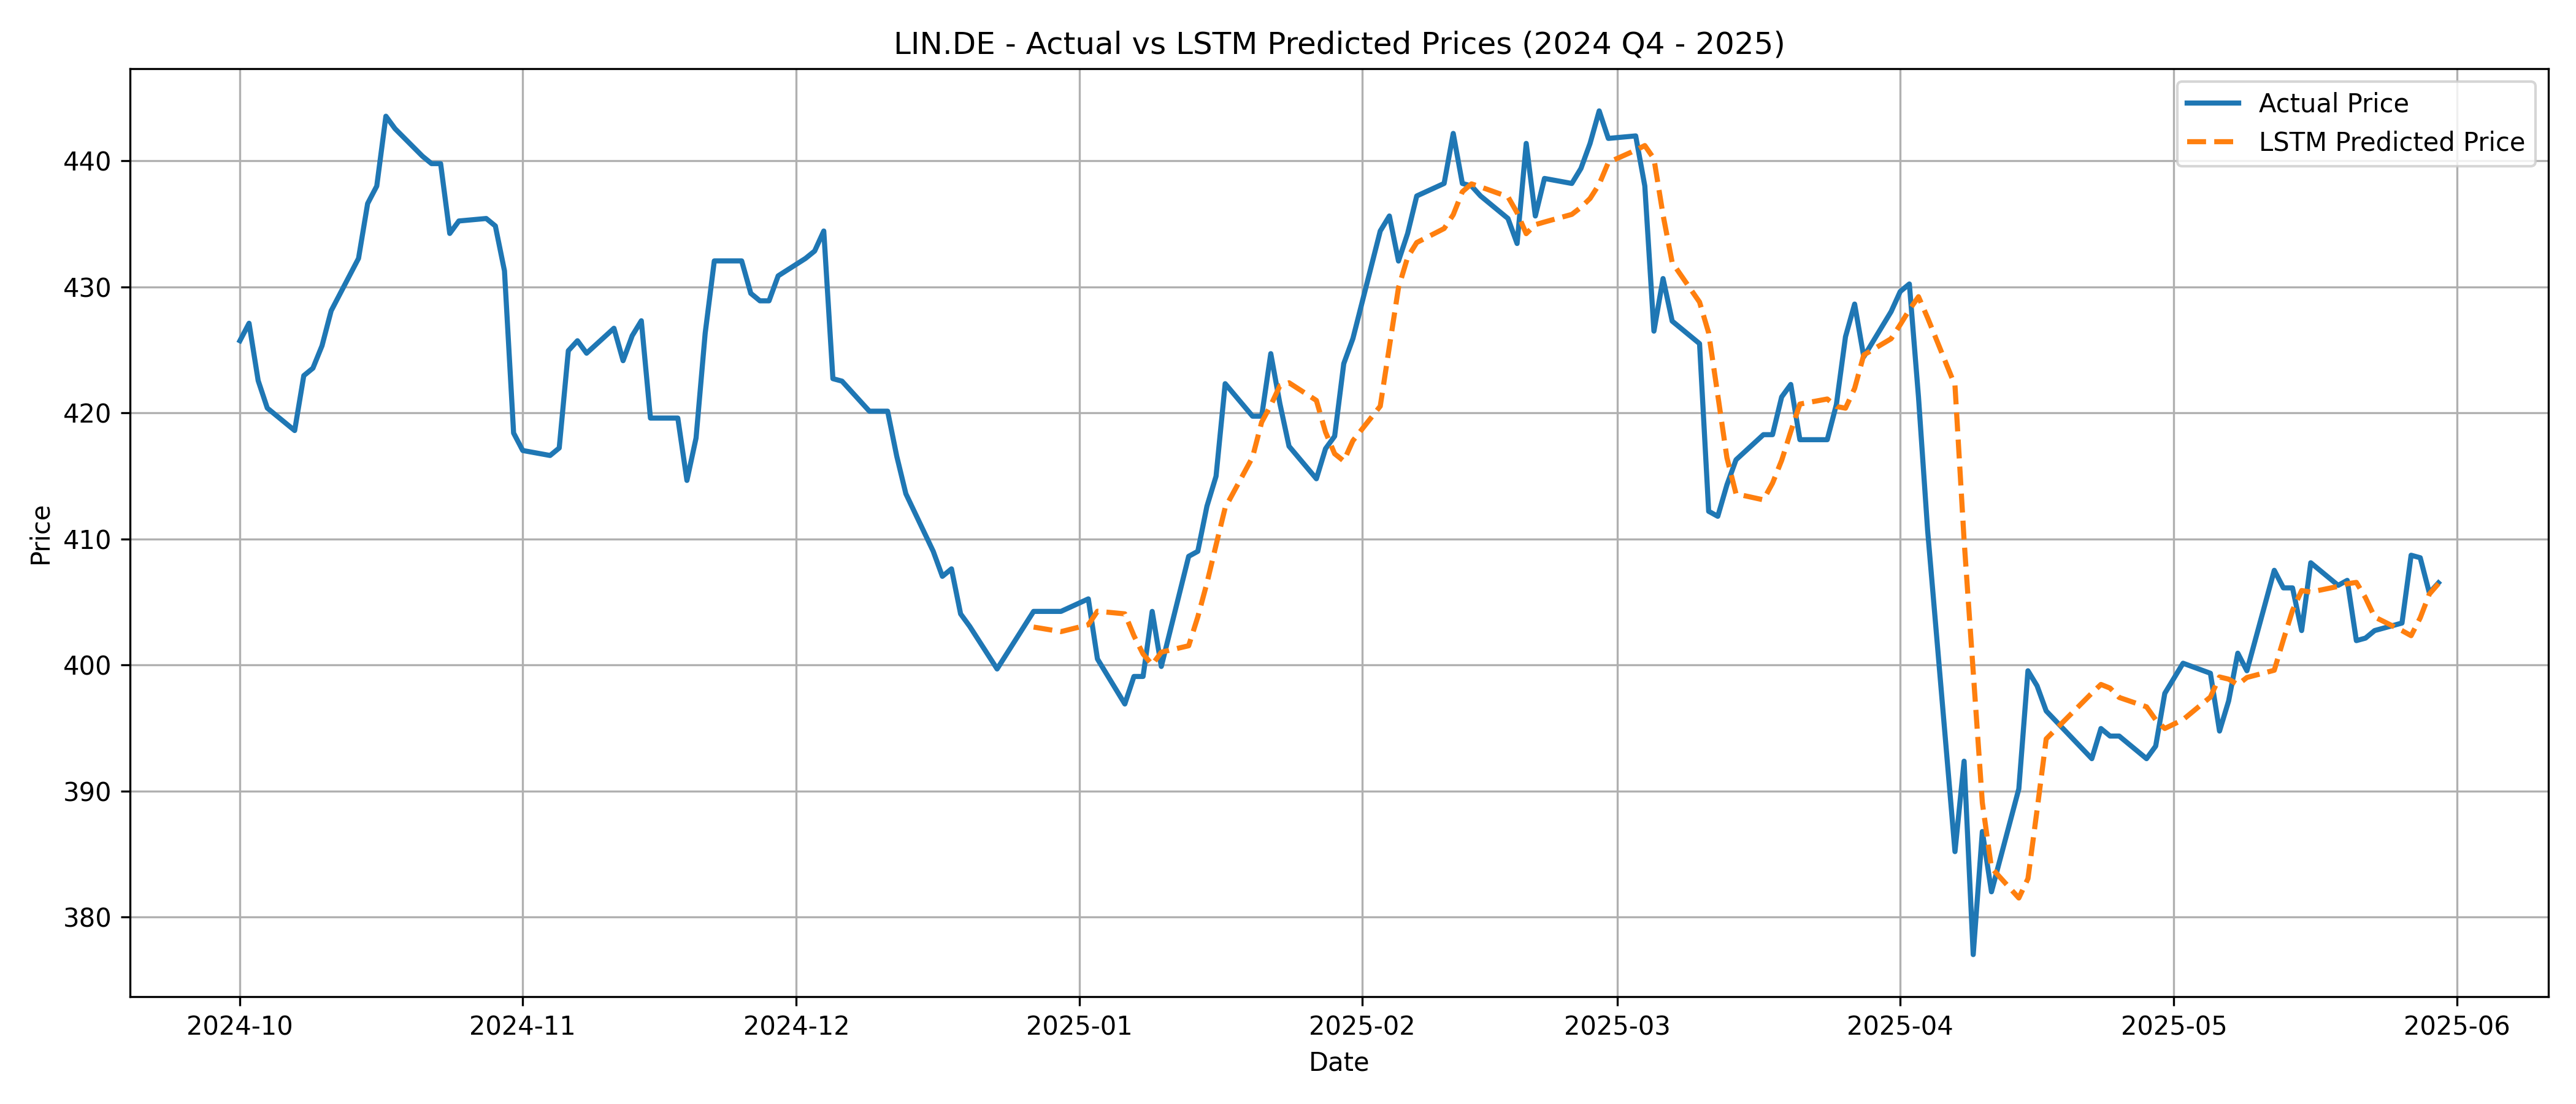

Displaying MC.PA_lstm_prediction.png


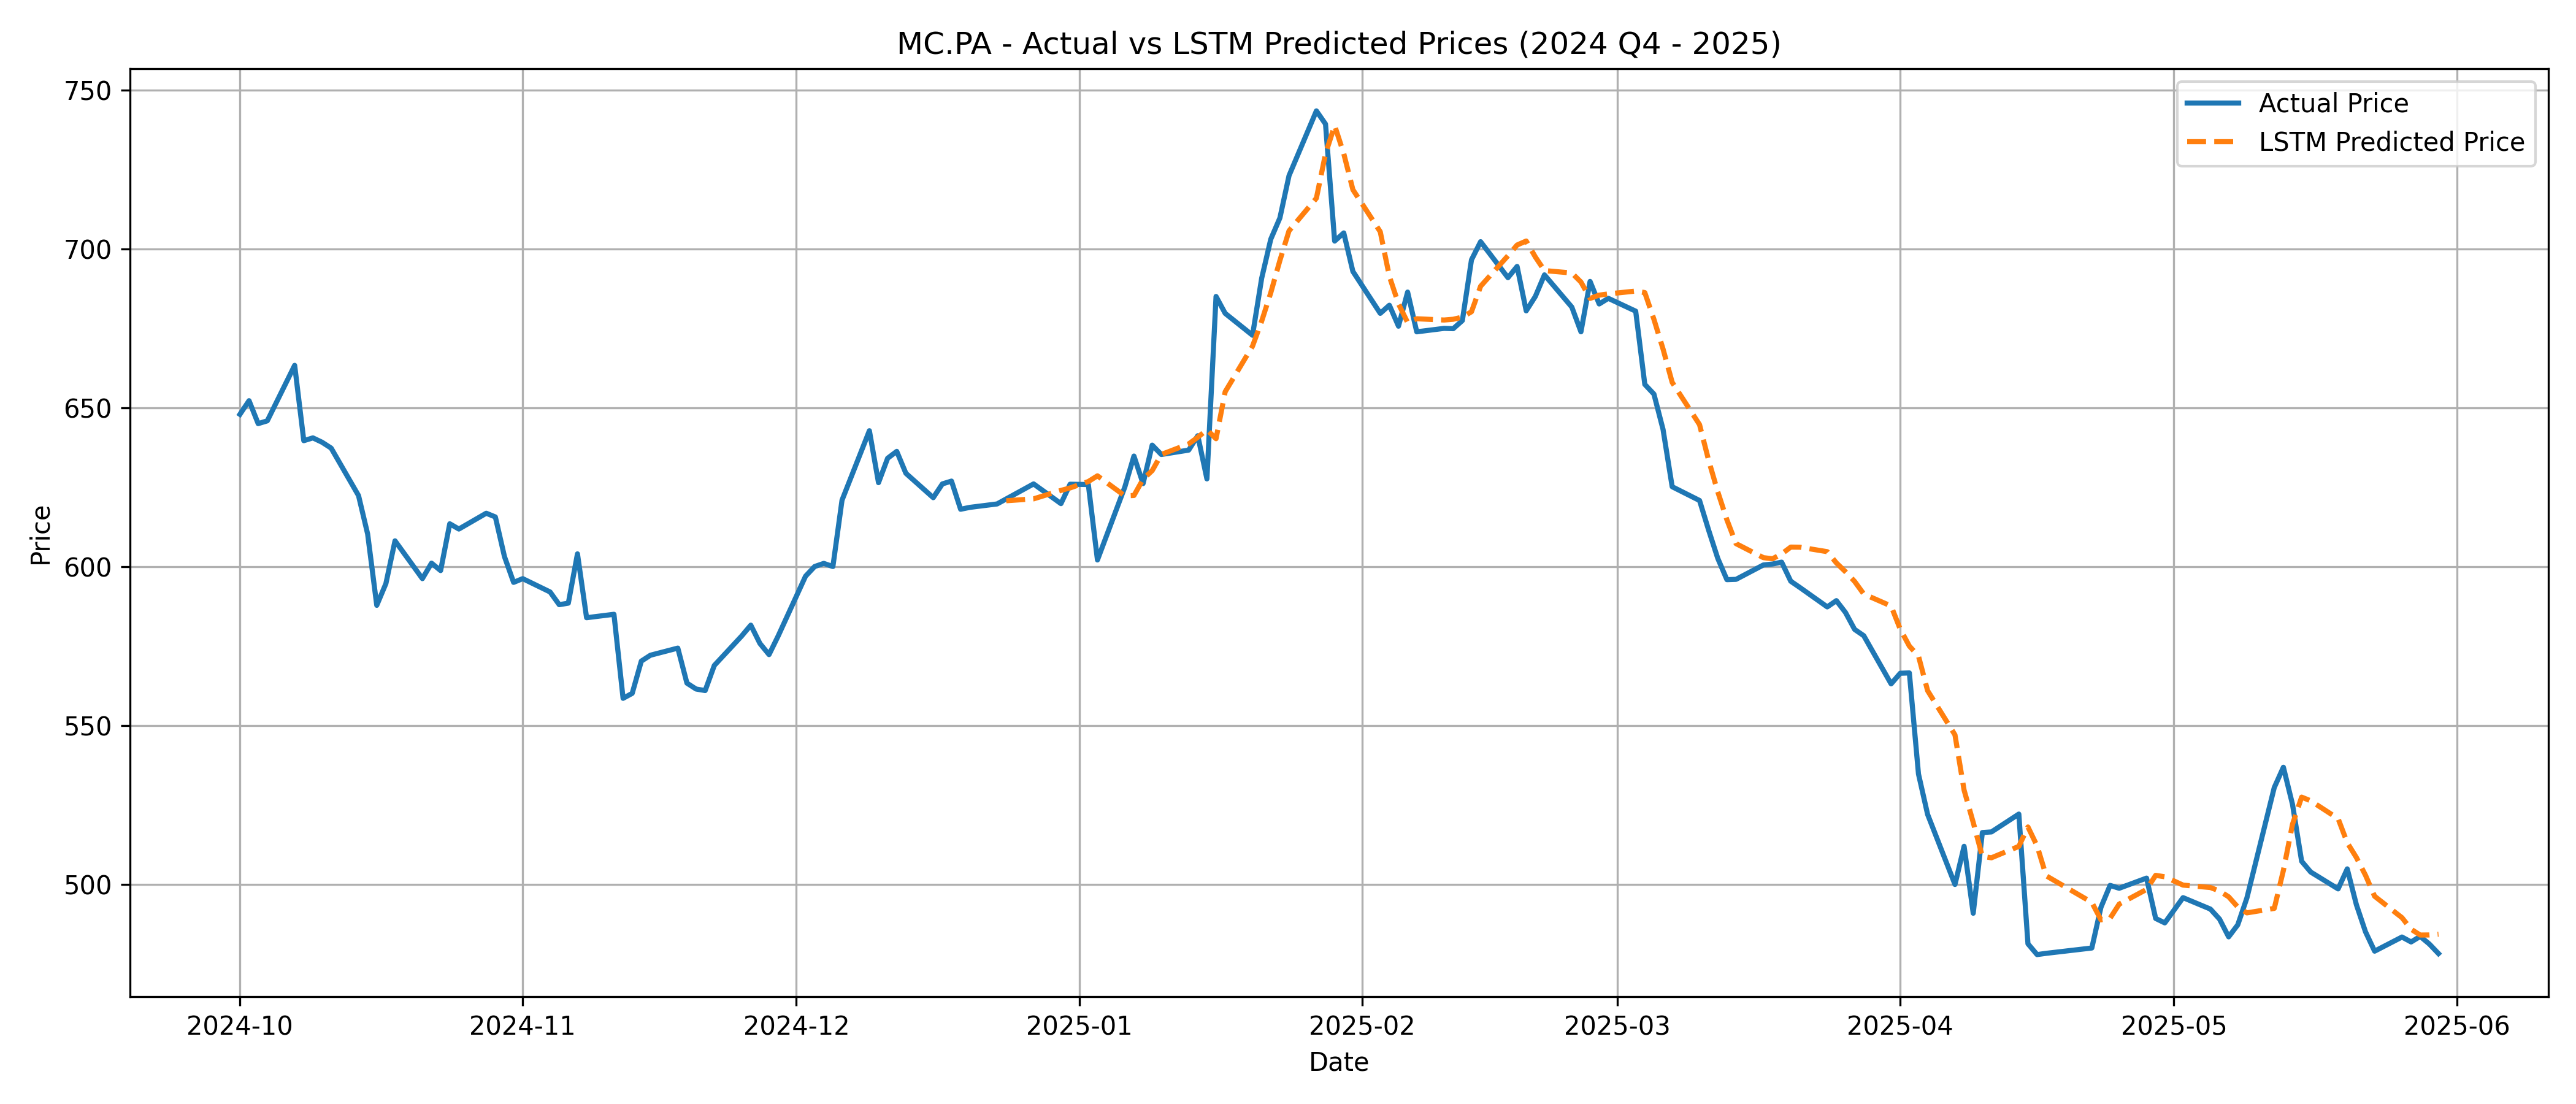

Displaying META_lstm_prediction.png


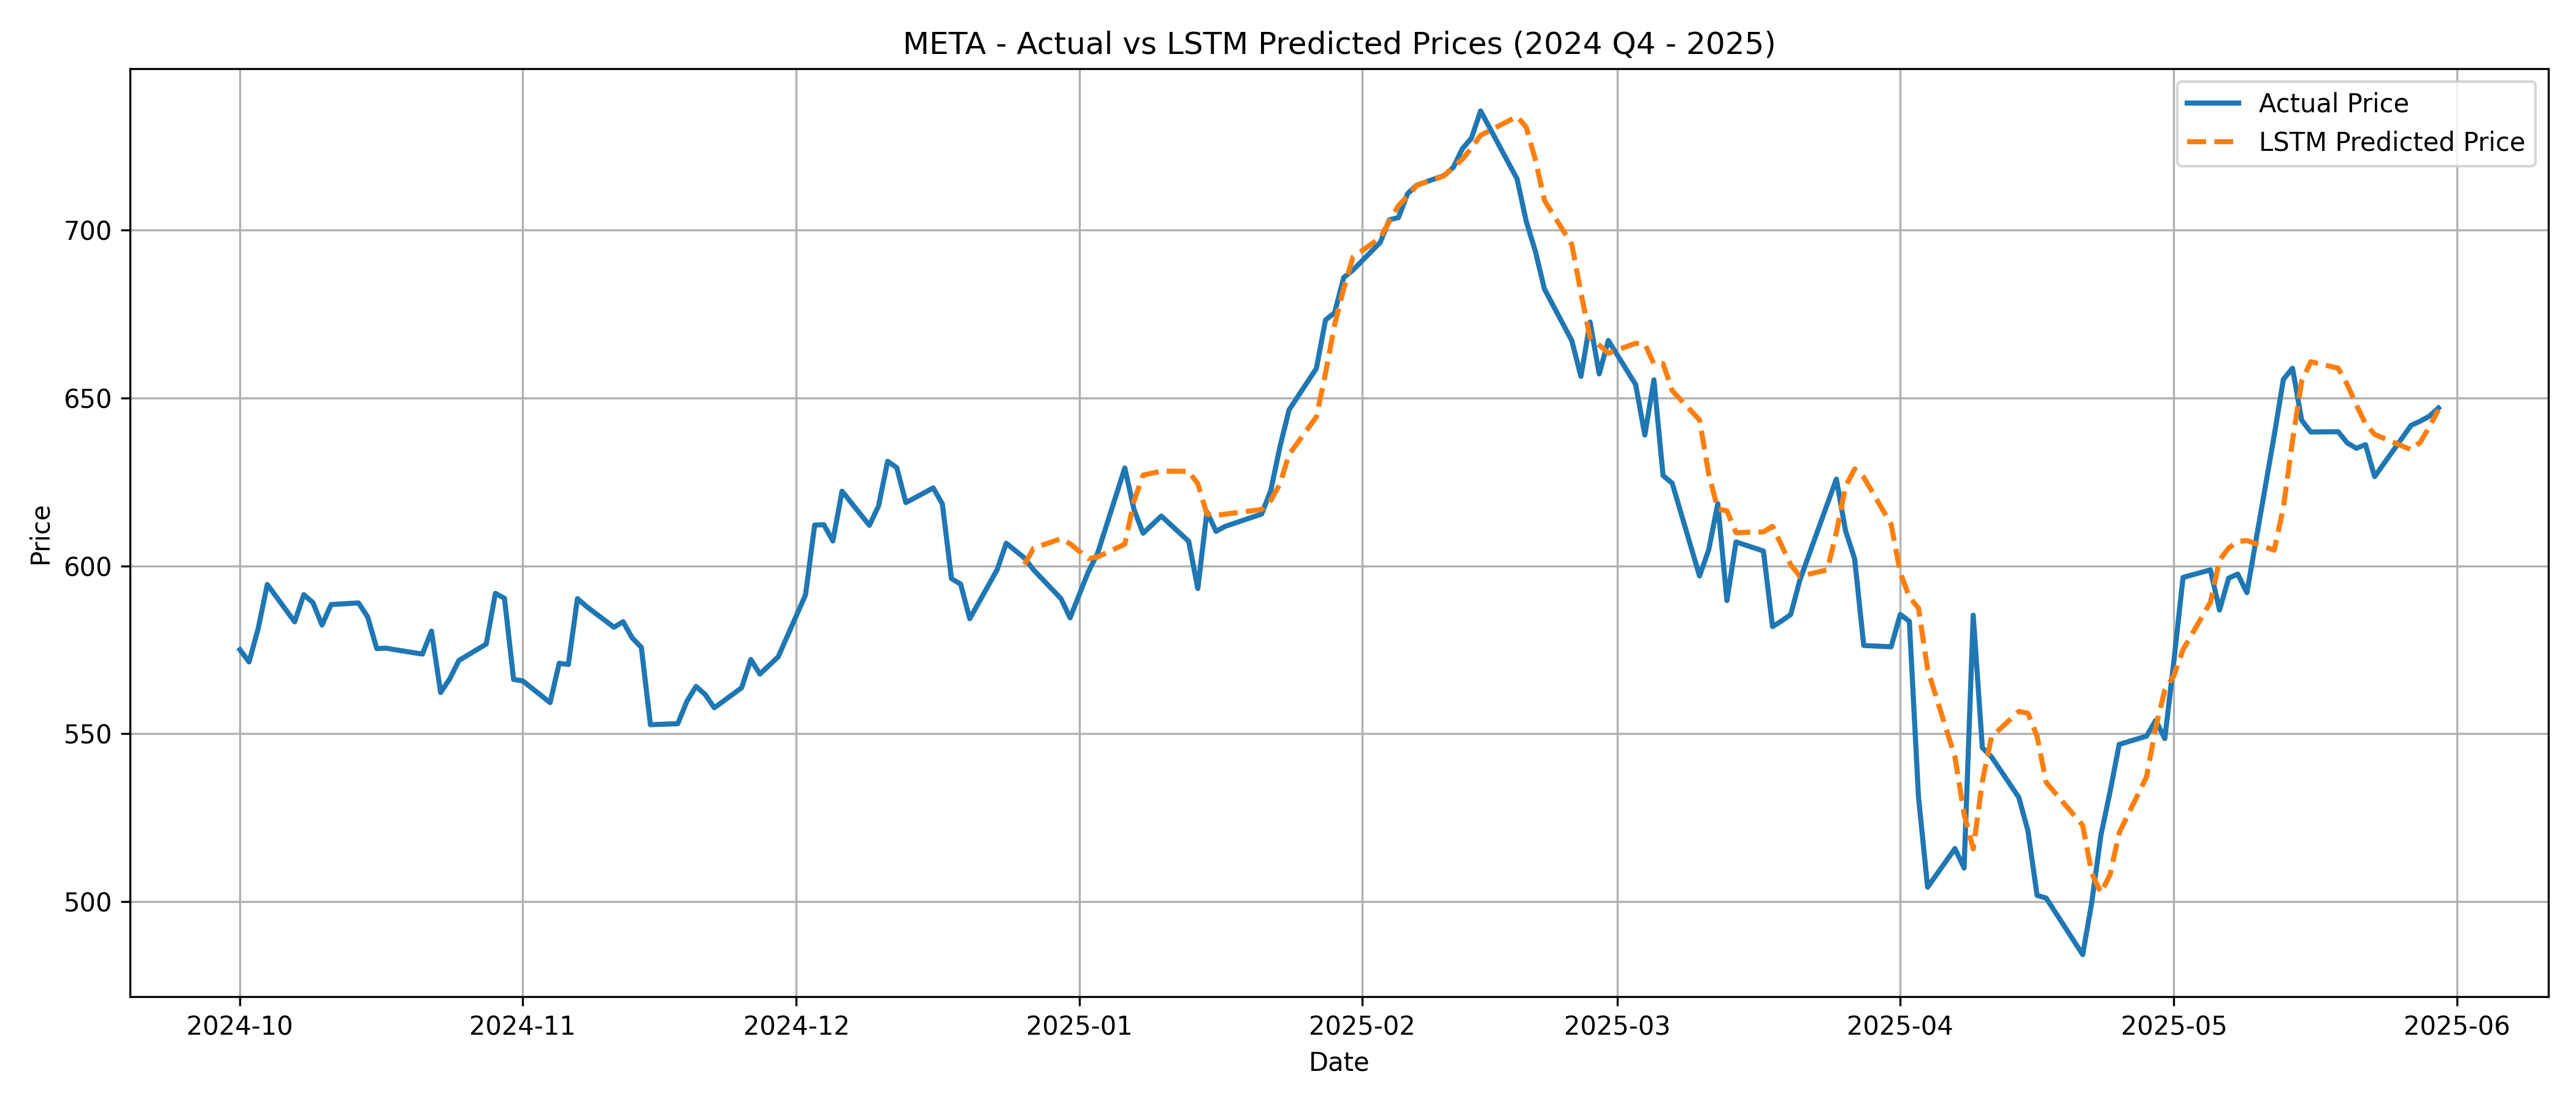

Displaying MSFT_lstm_prediction.png


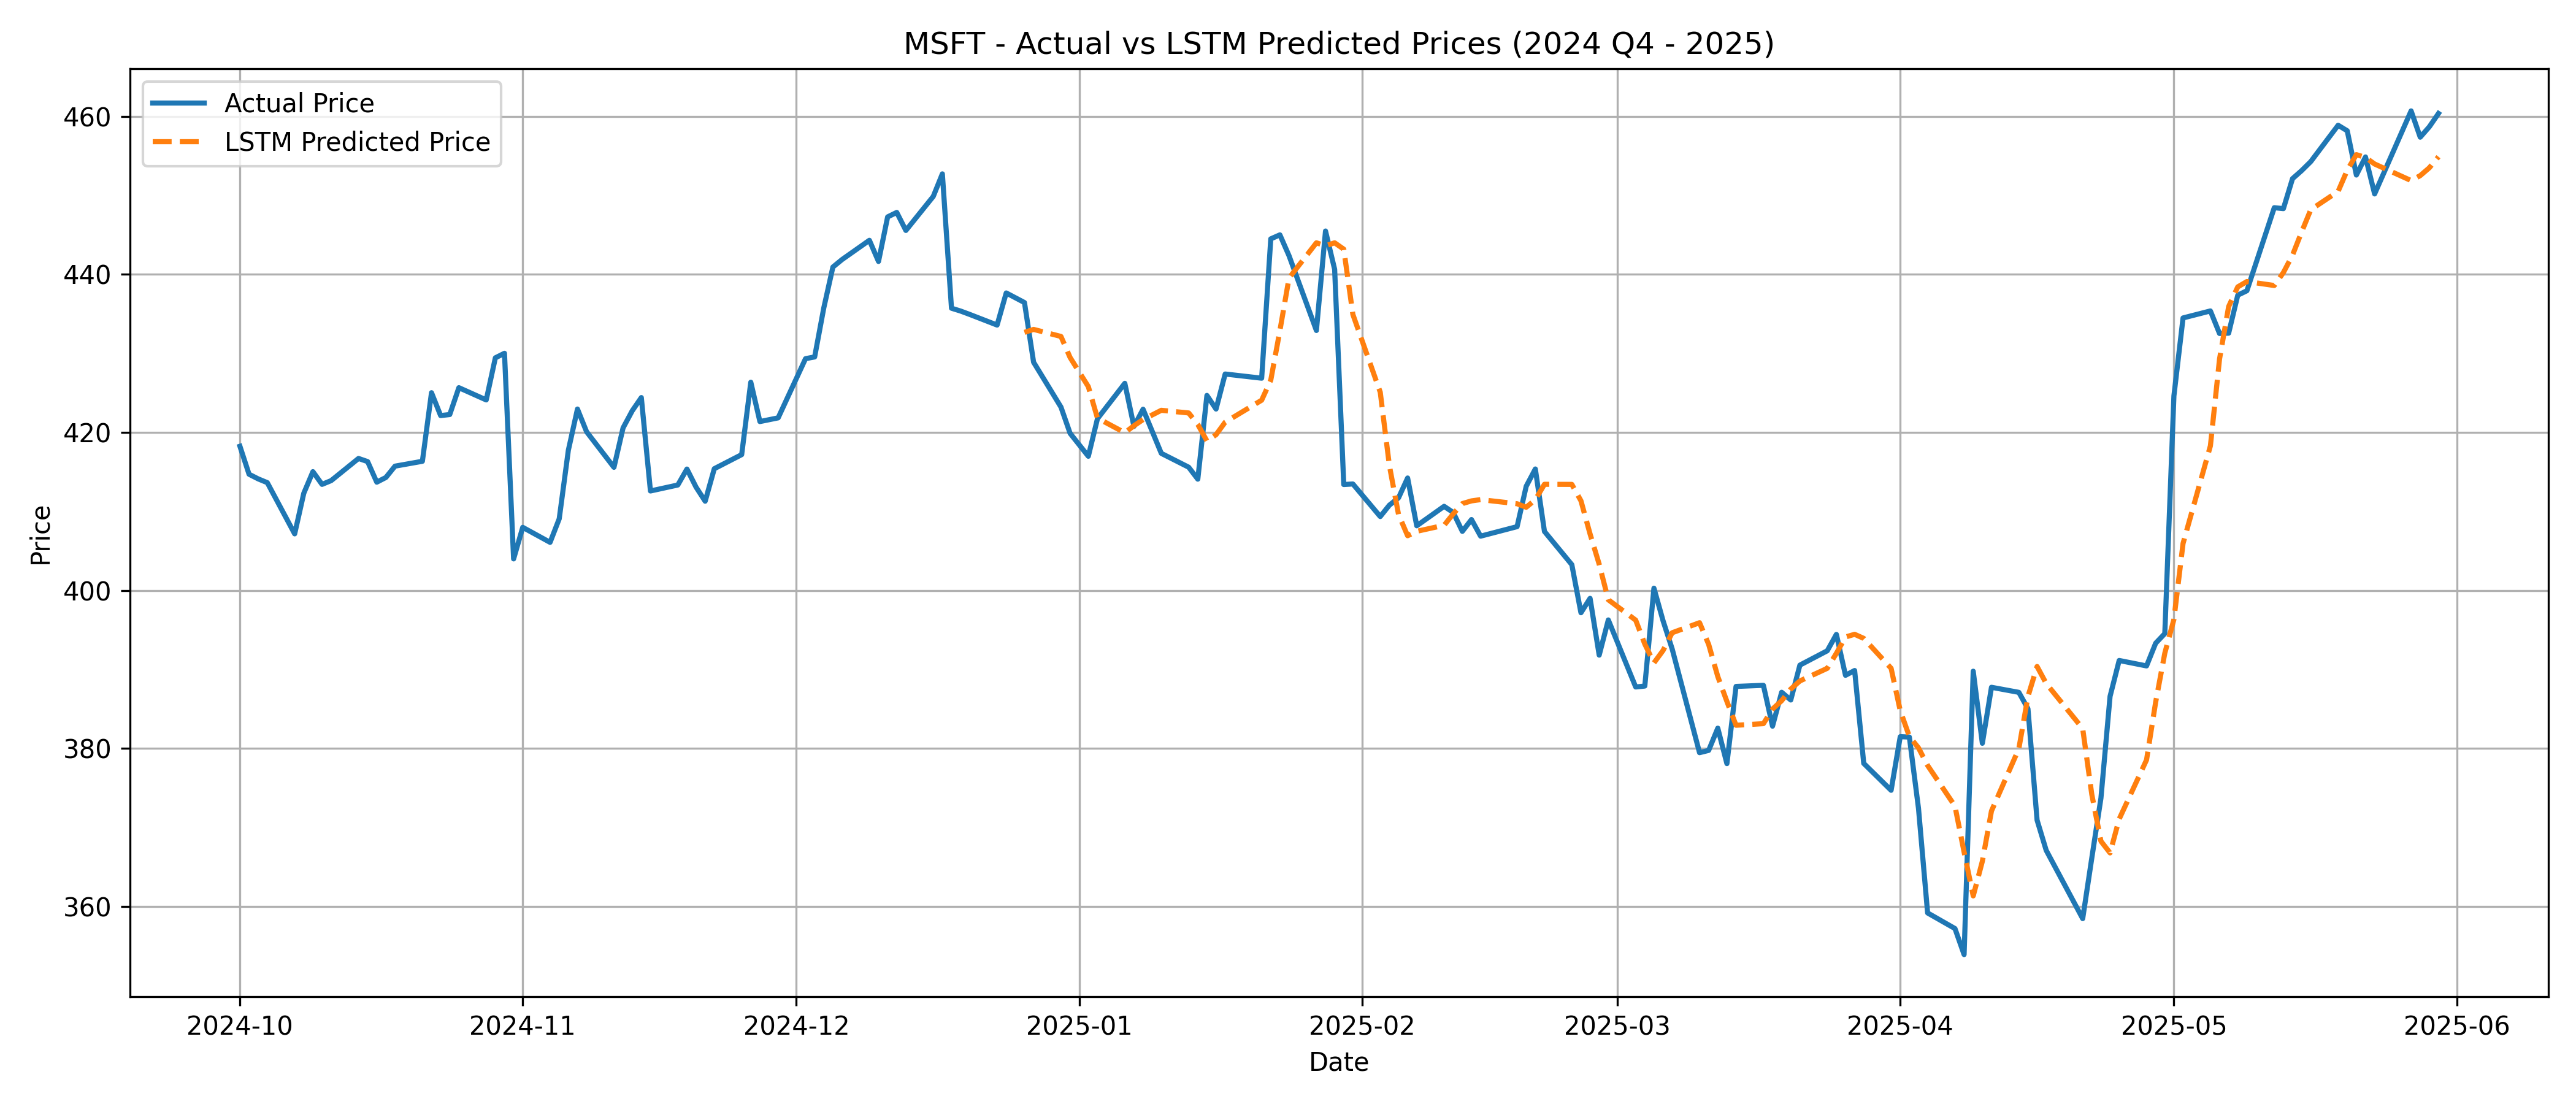

Displaying NESN.SW_lstm_prediction.png


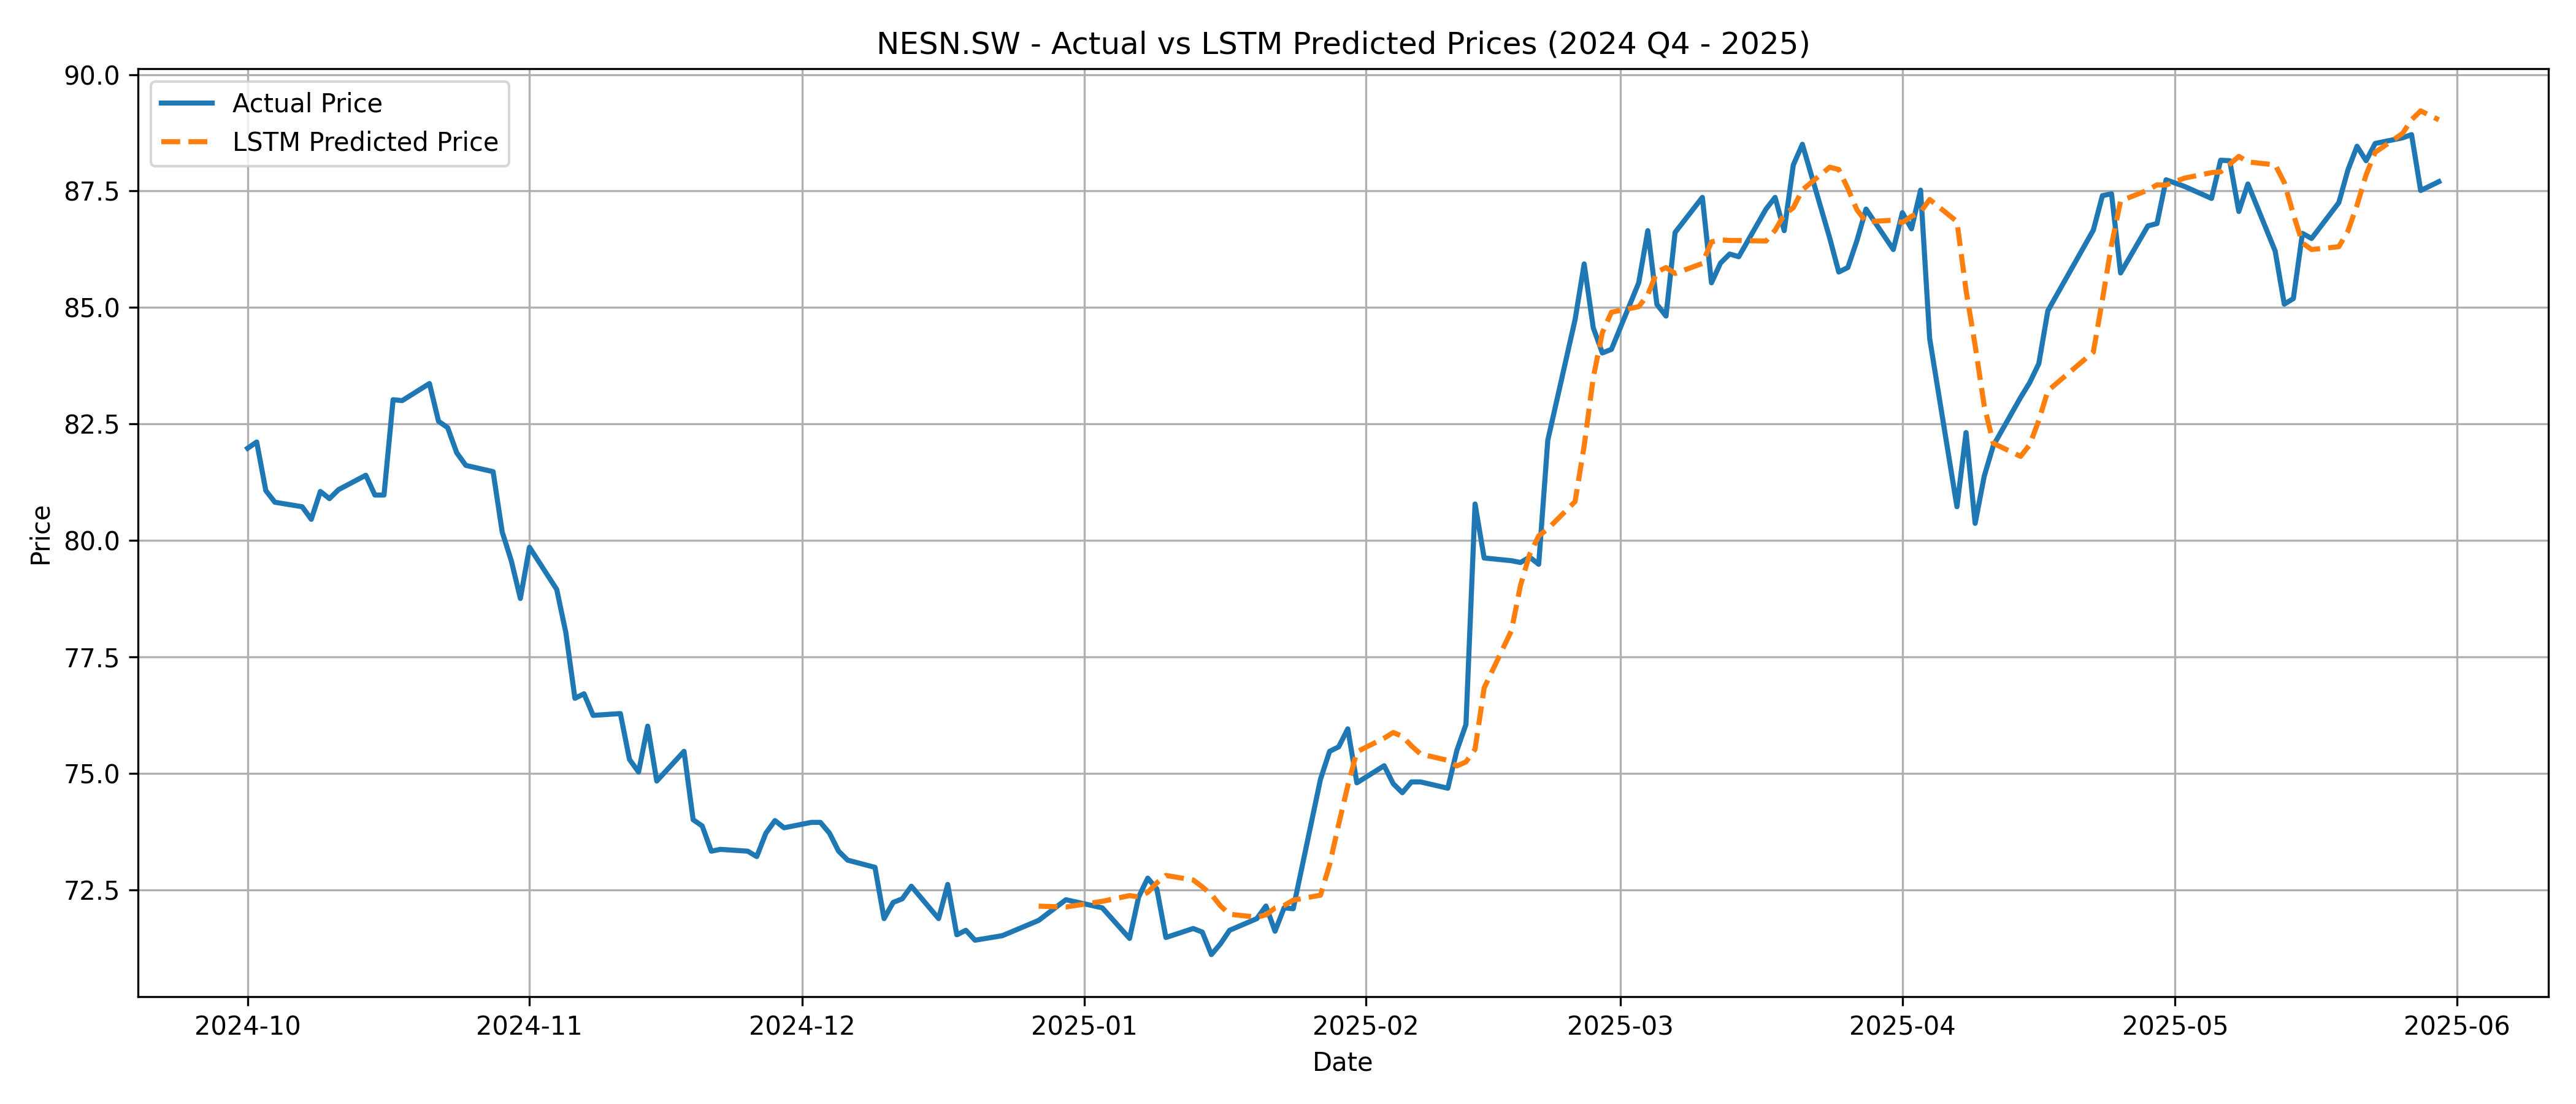

Displaying NVDA_lstm_prediction.png


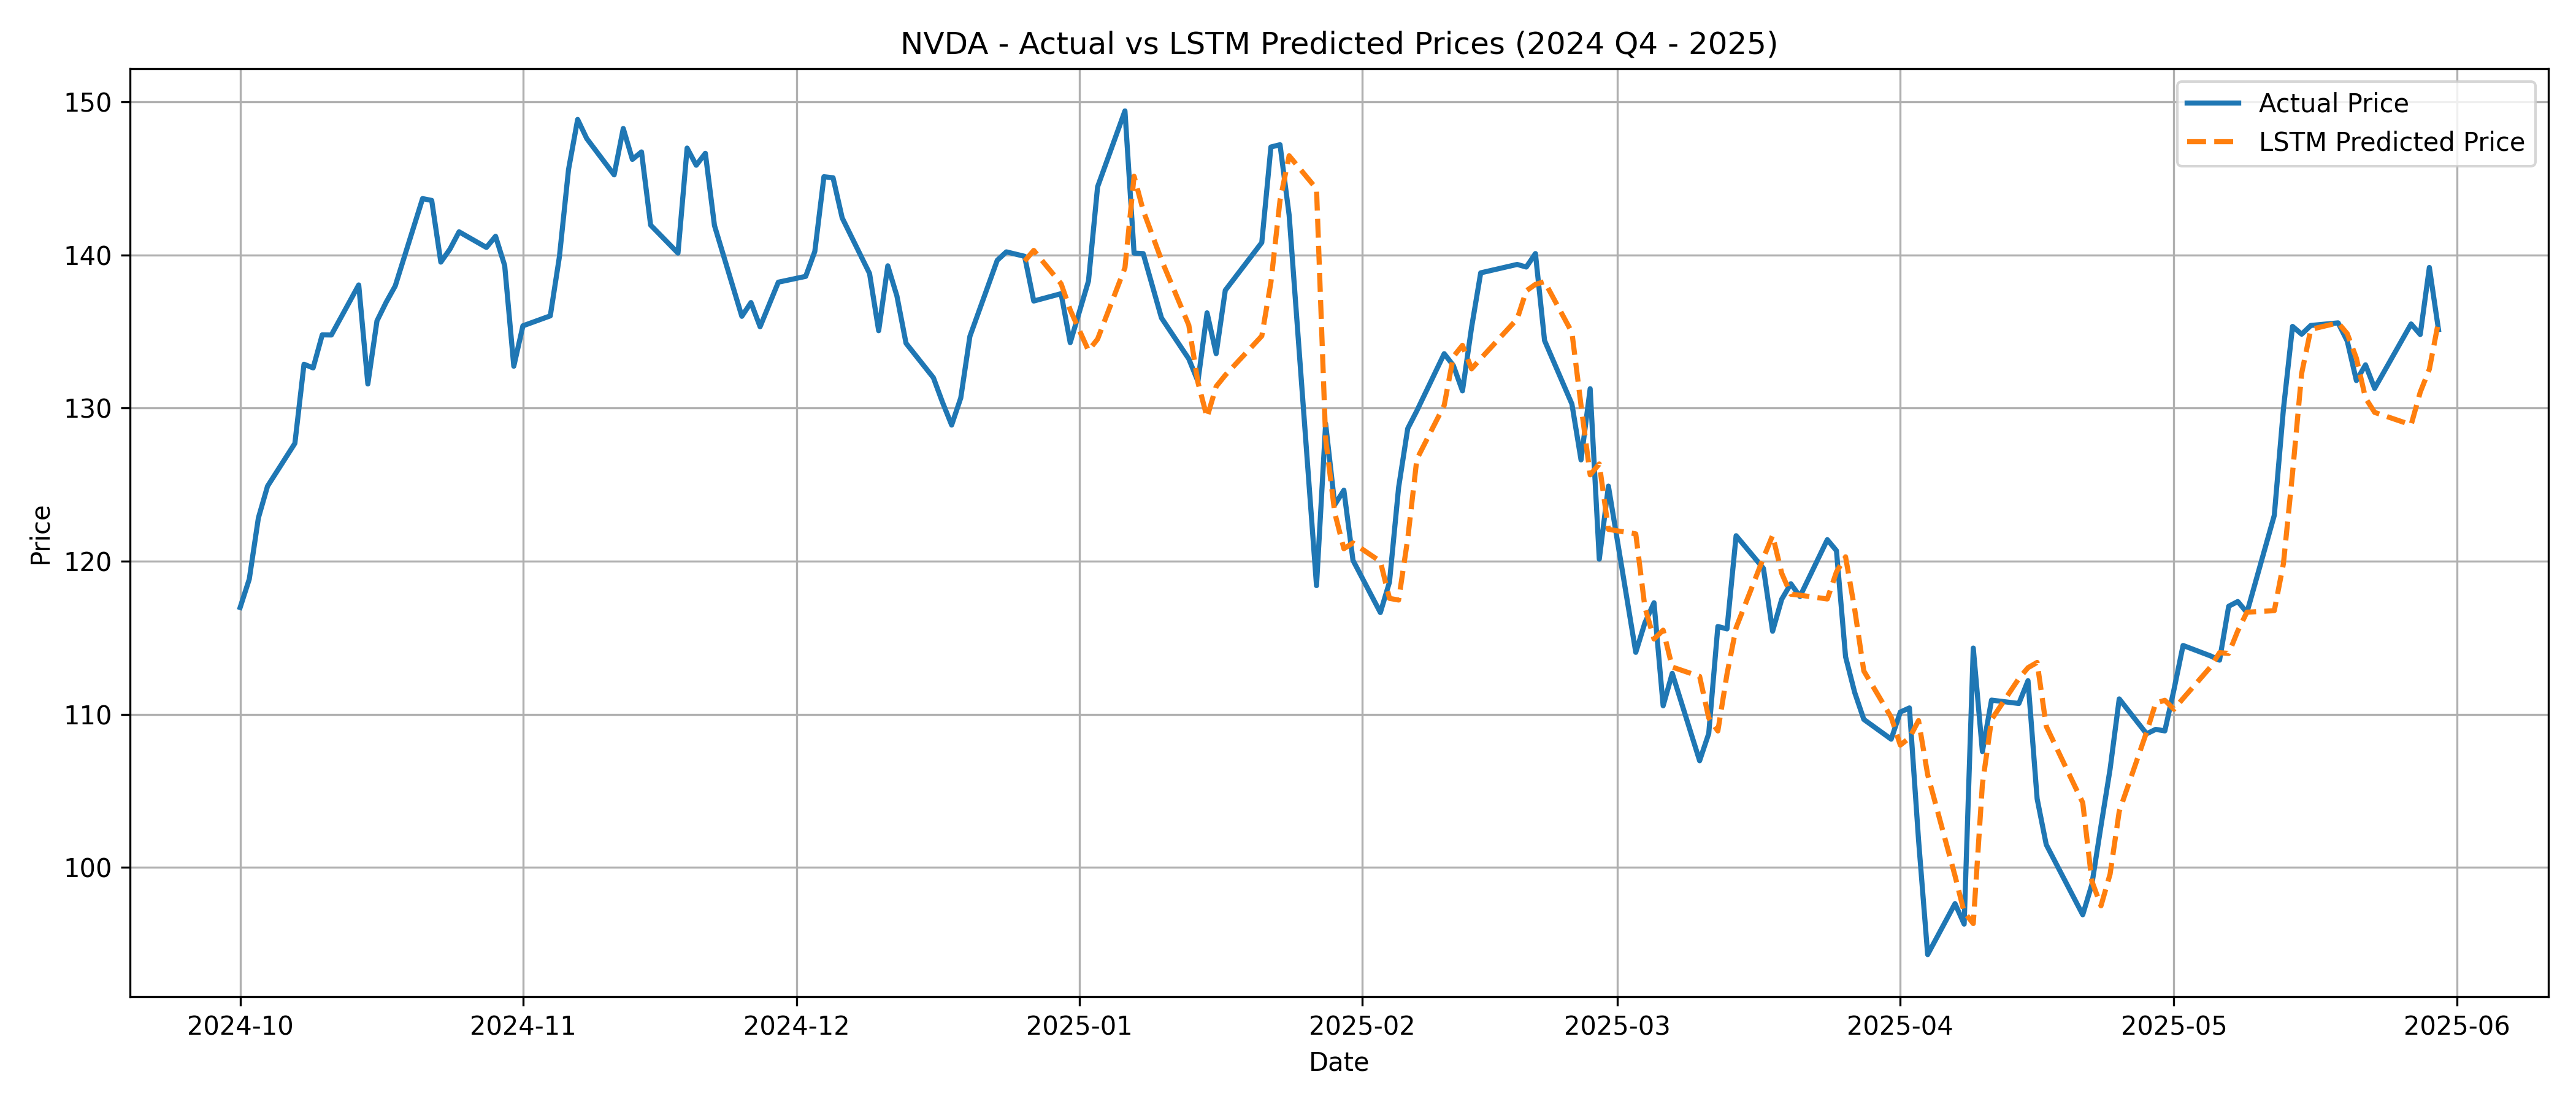

Displaying OR.PA_lstm_prediction.png


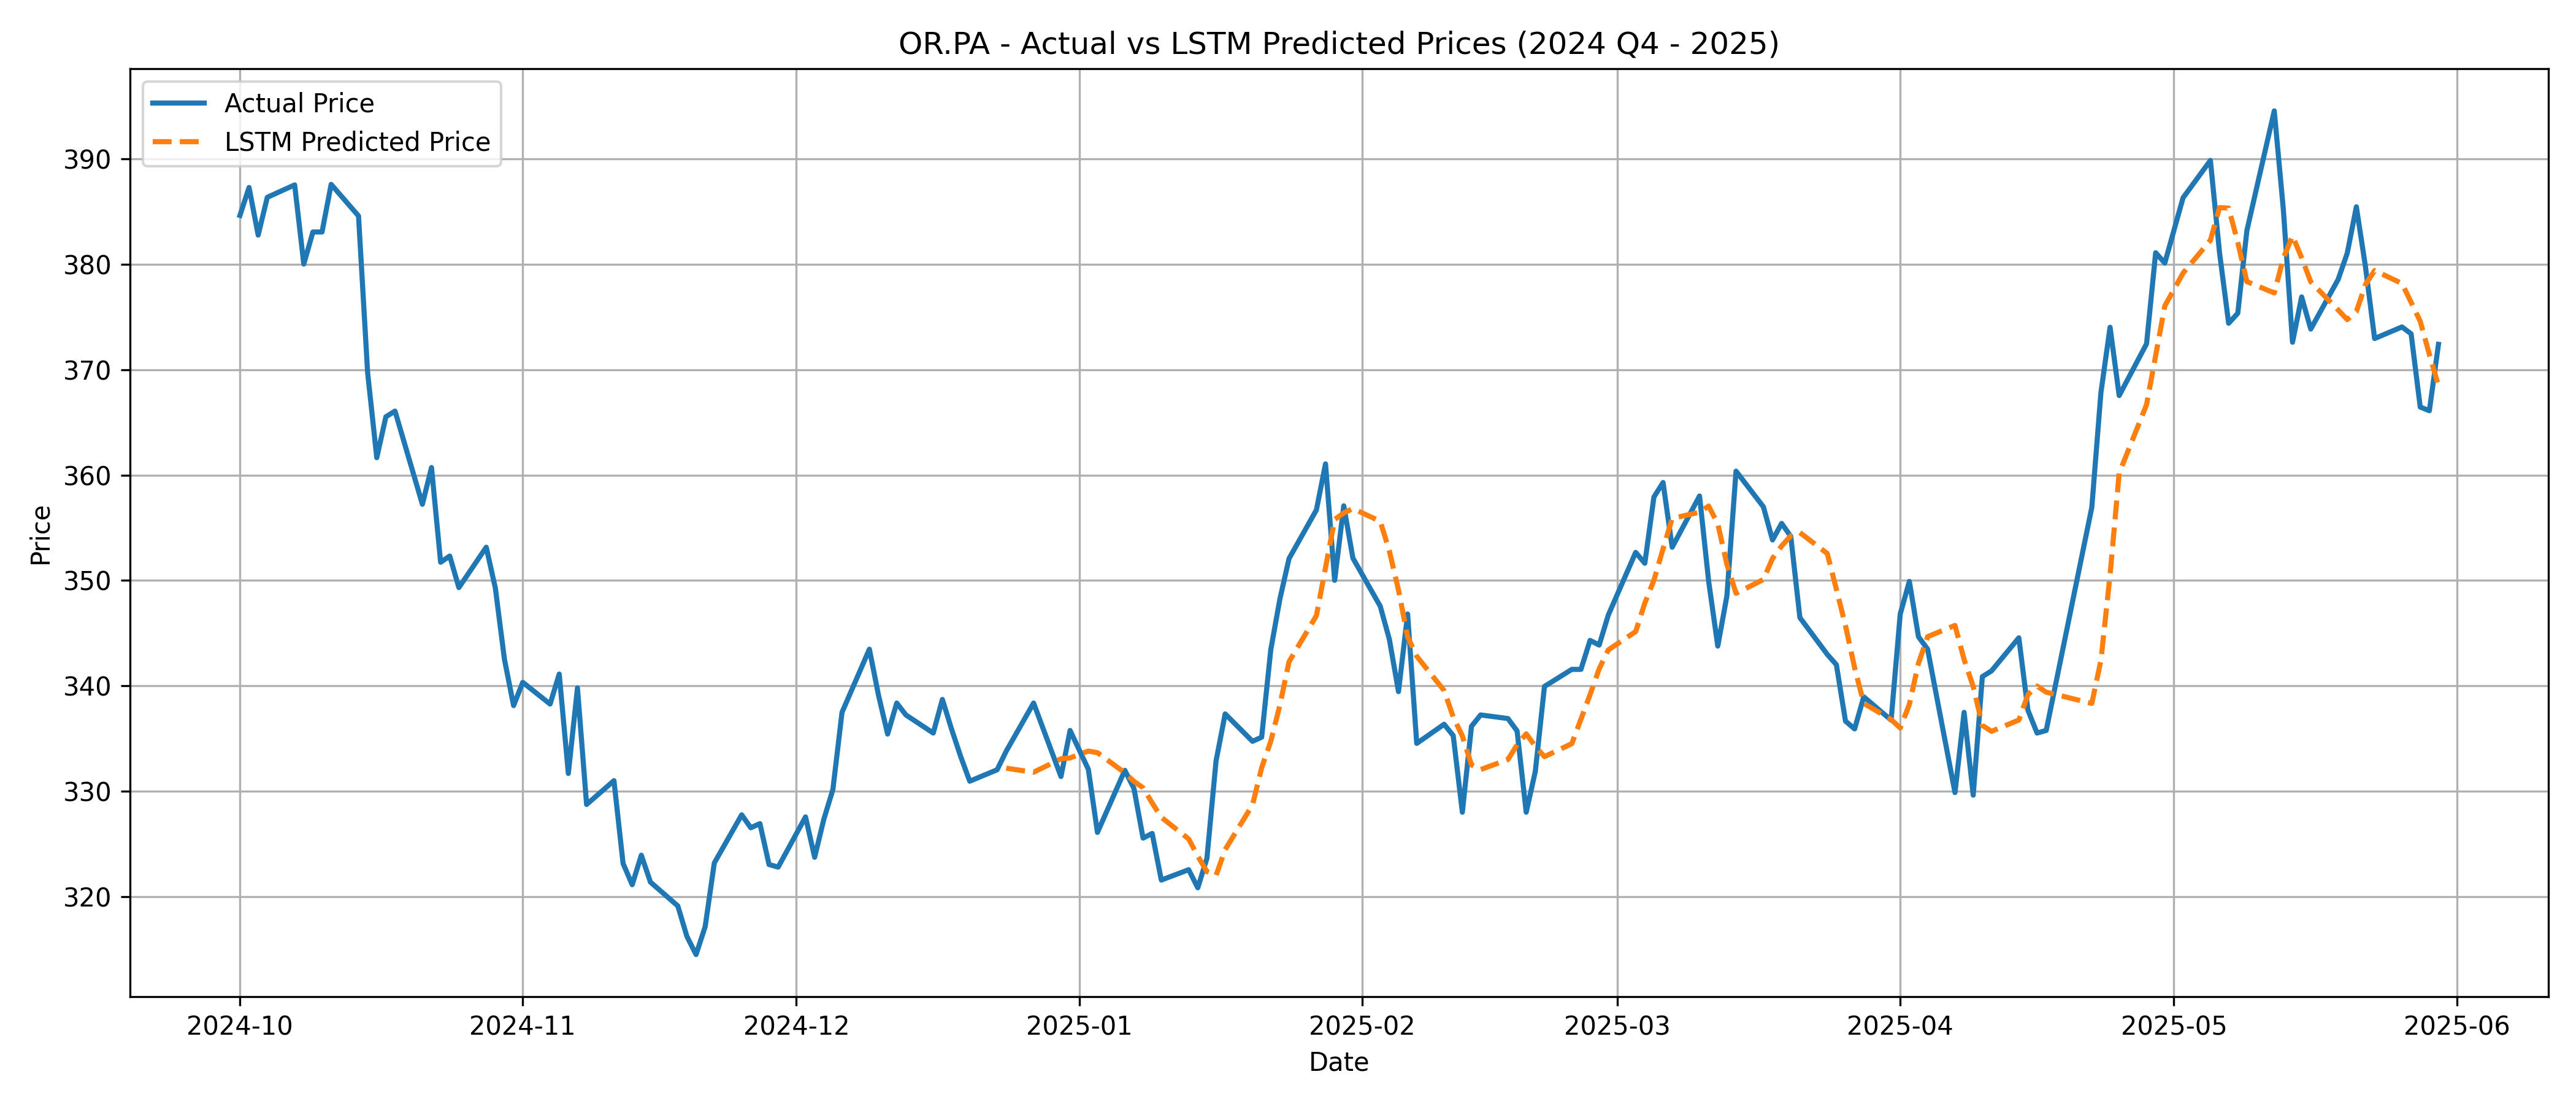

Displaying SAP.DE_lstm_prediction.png


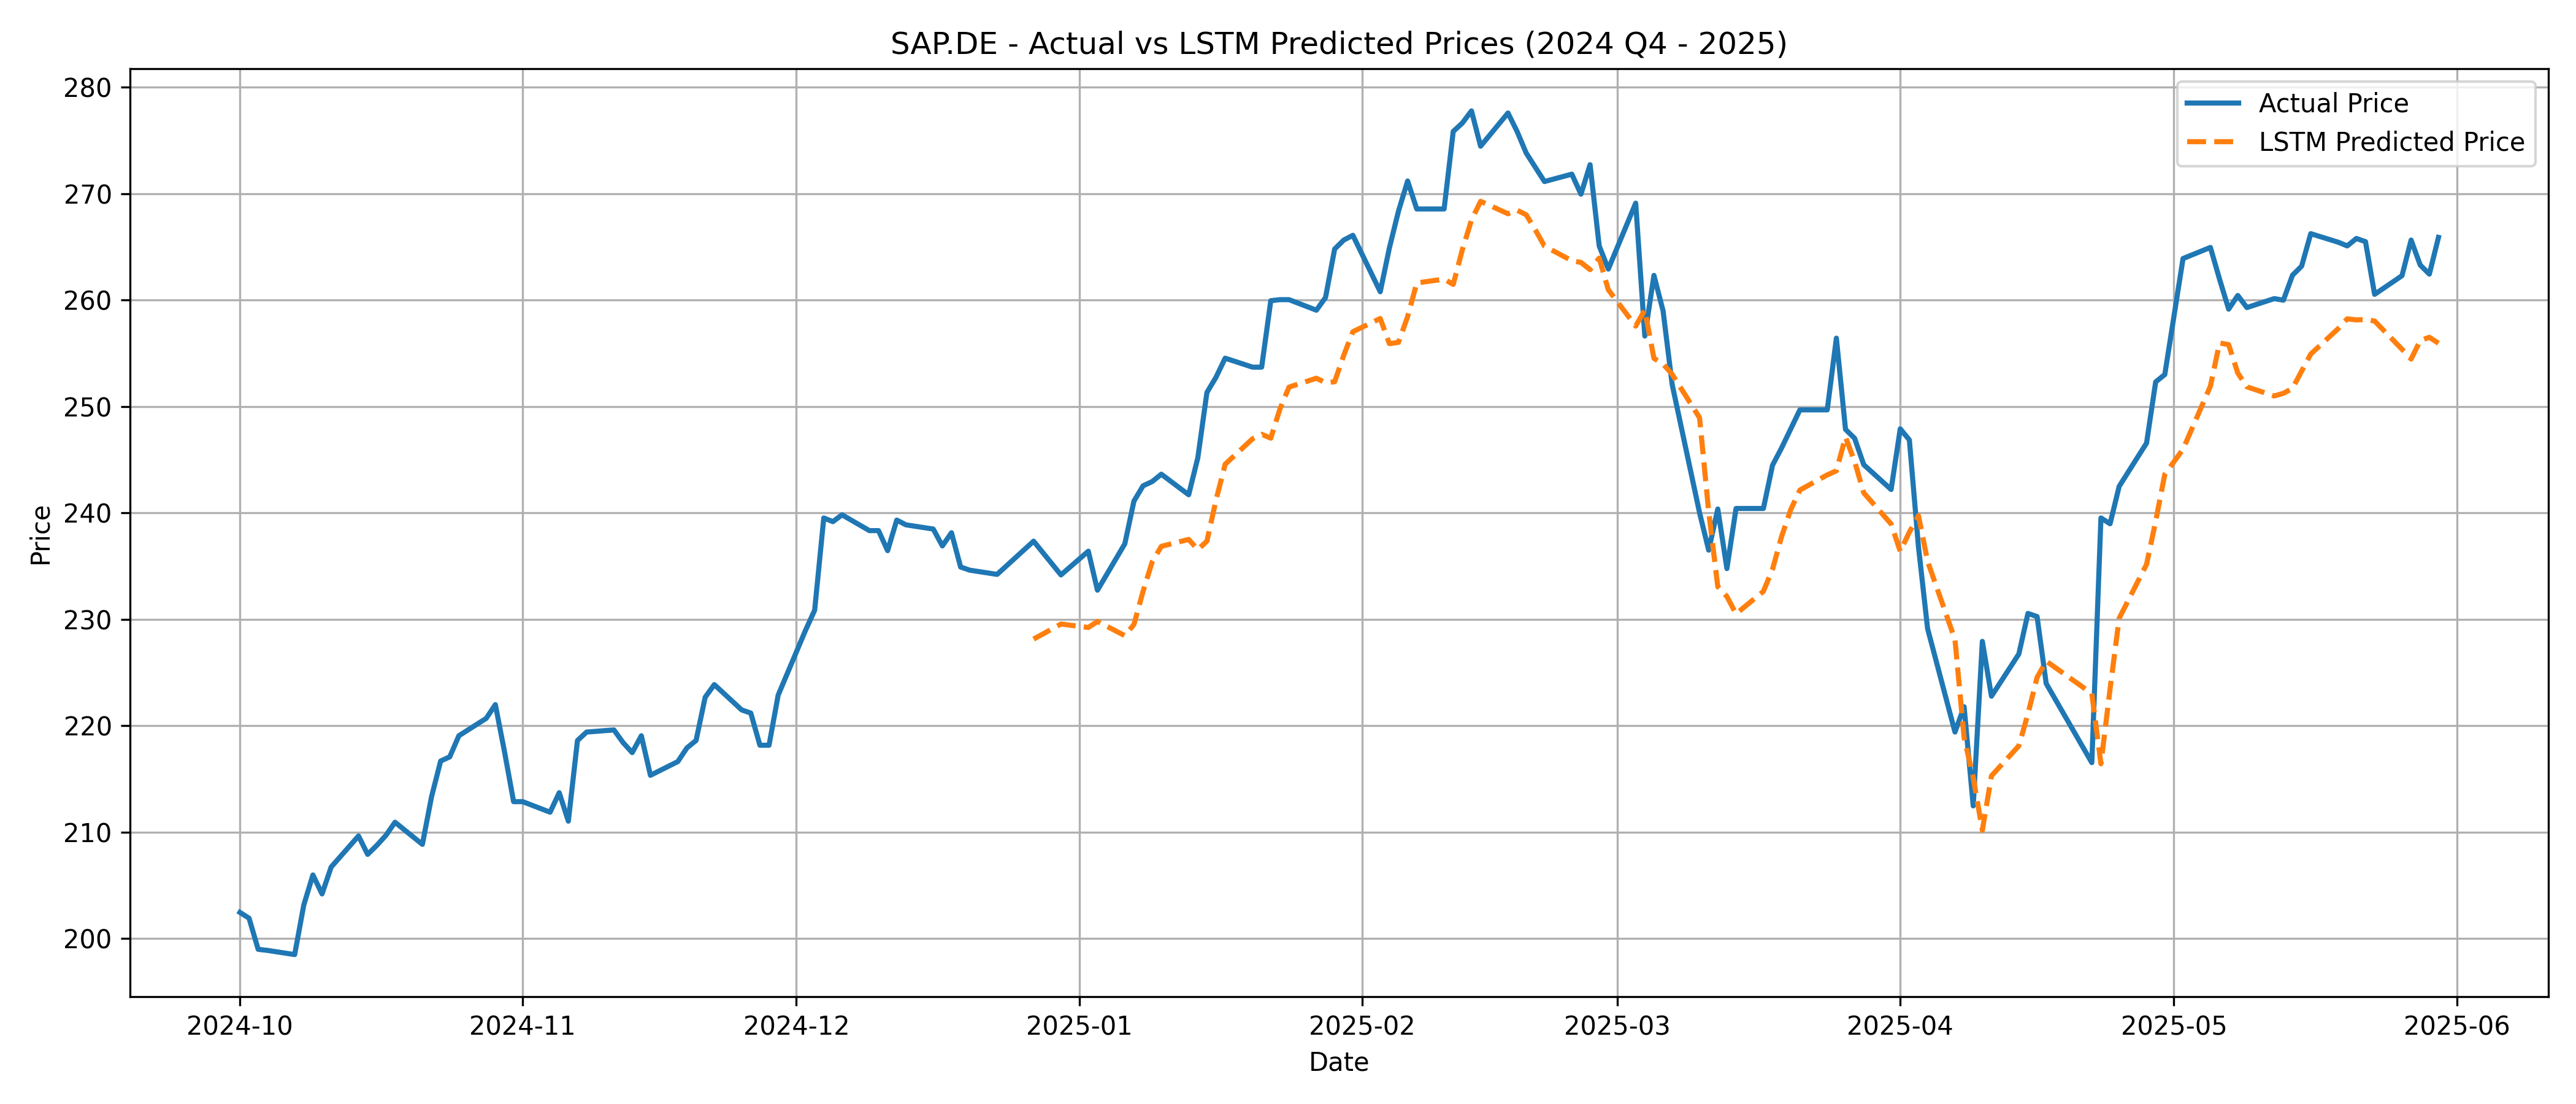

Displaying SIE.DE_lstm_prediction.png


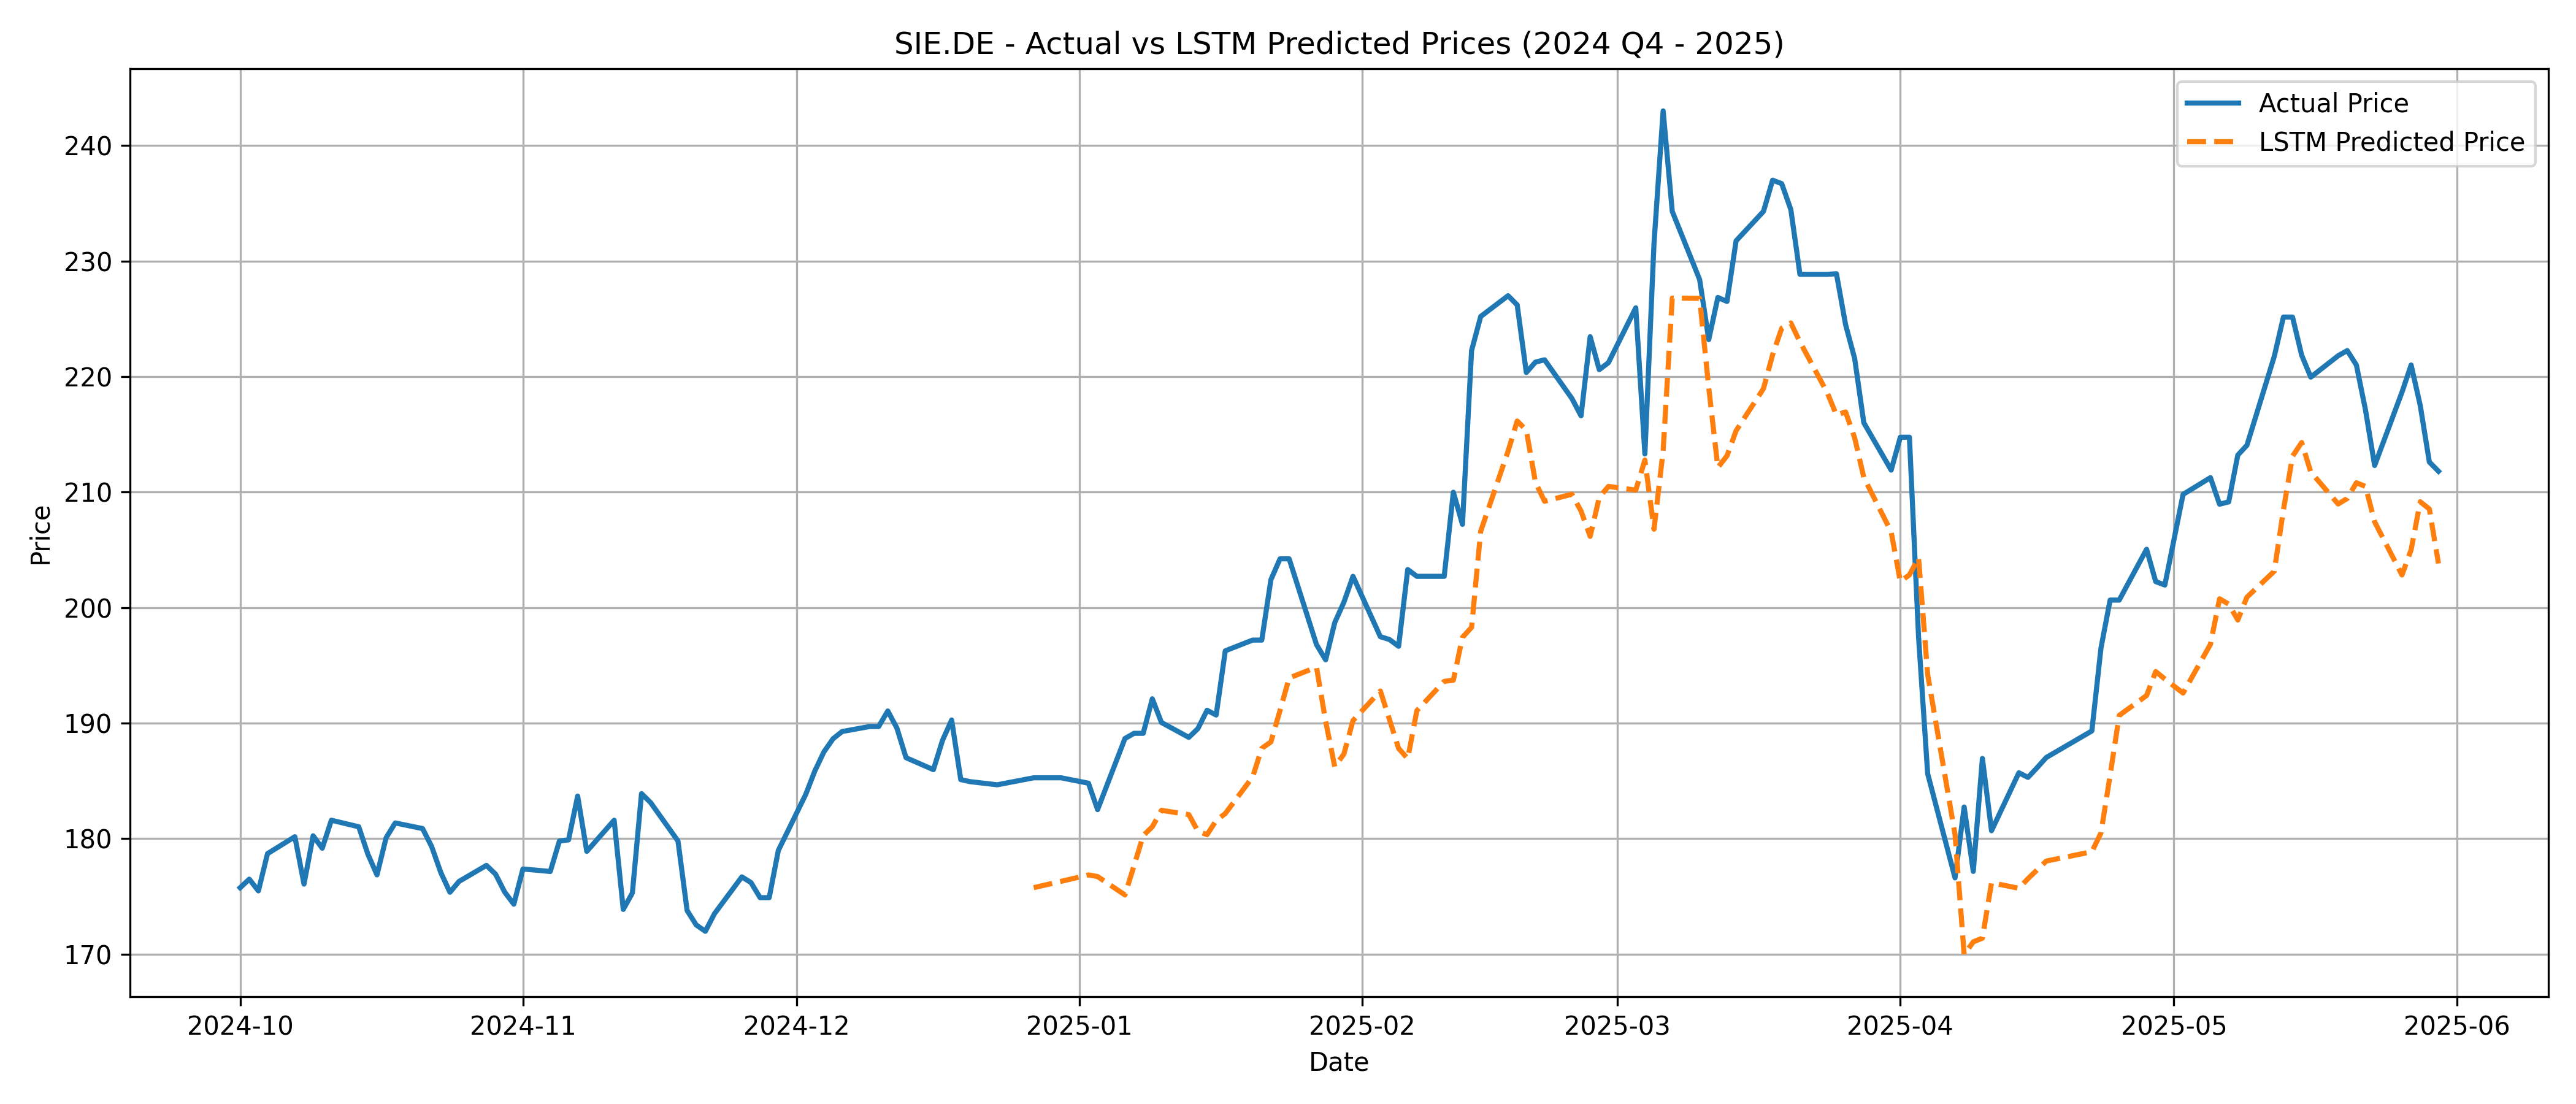

Displaying TSLA_lstm_prediction.png


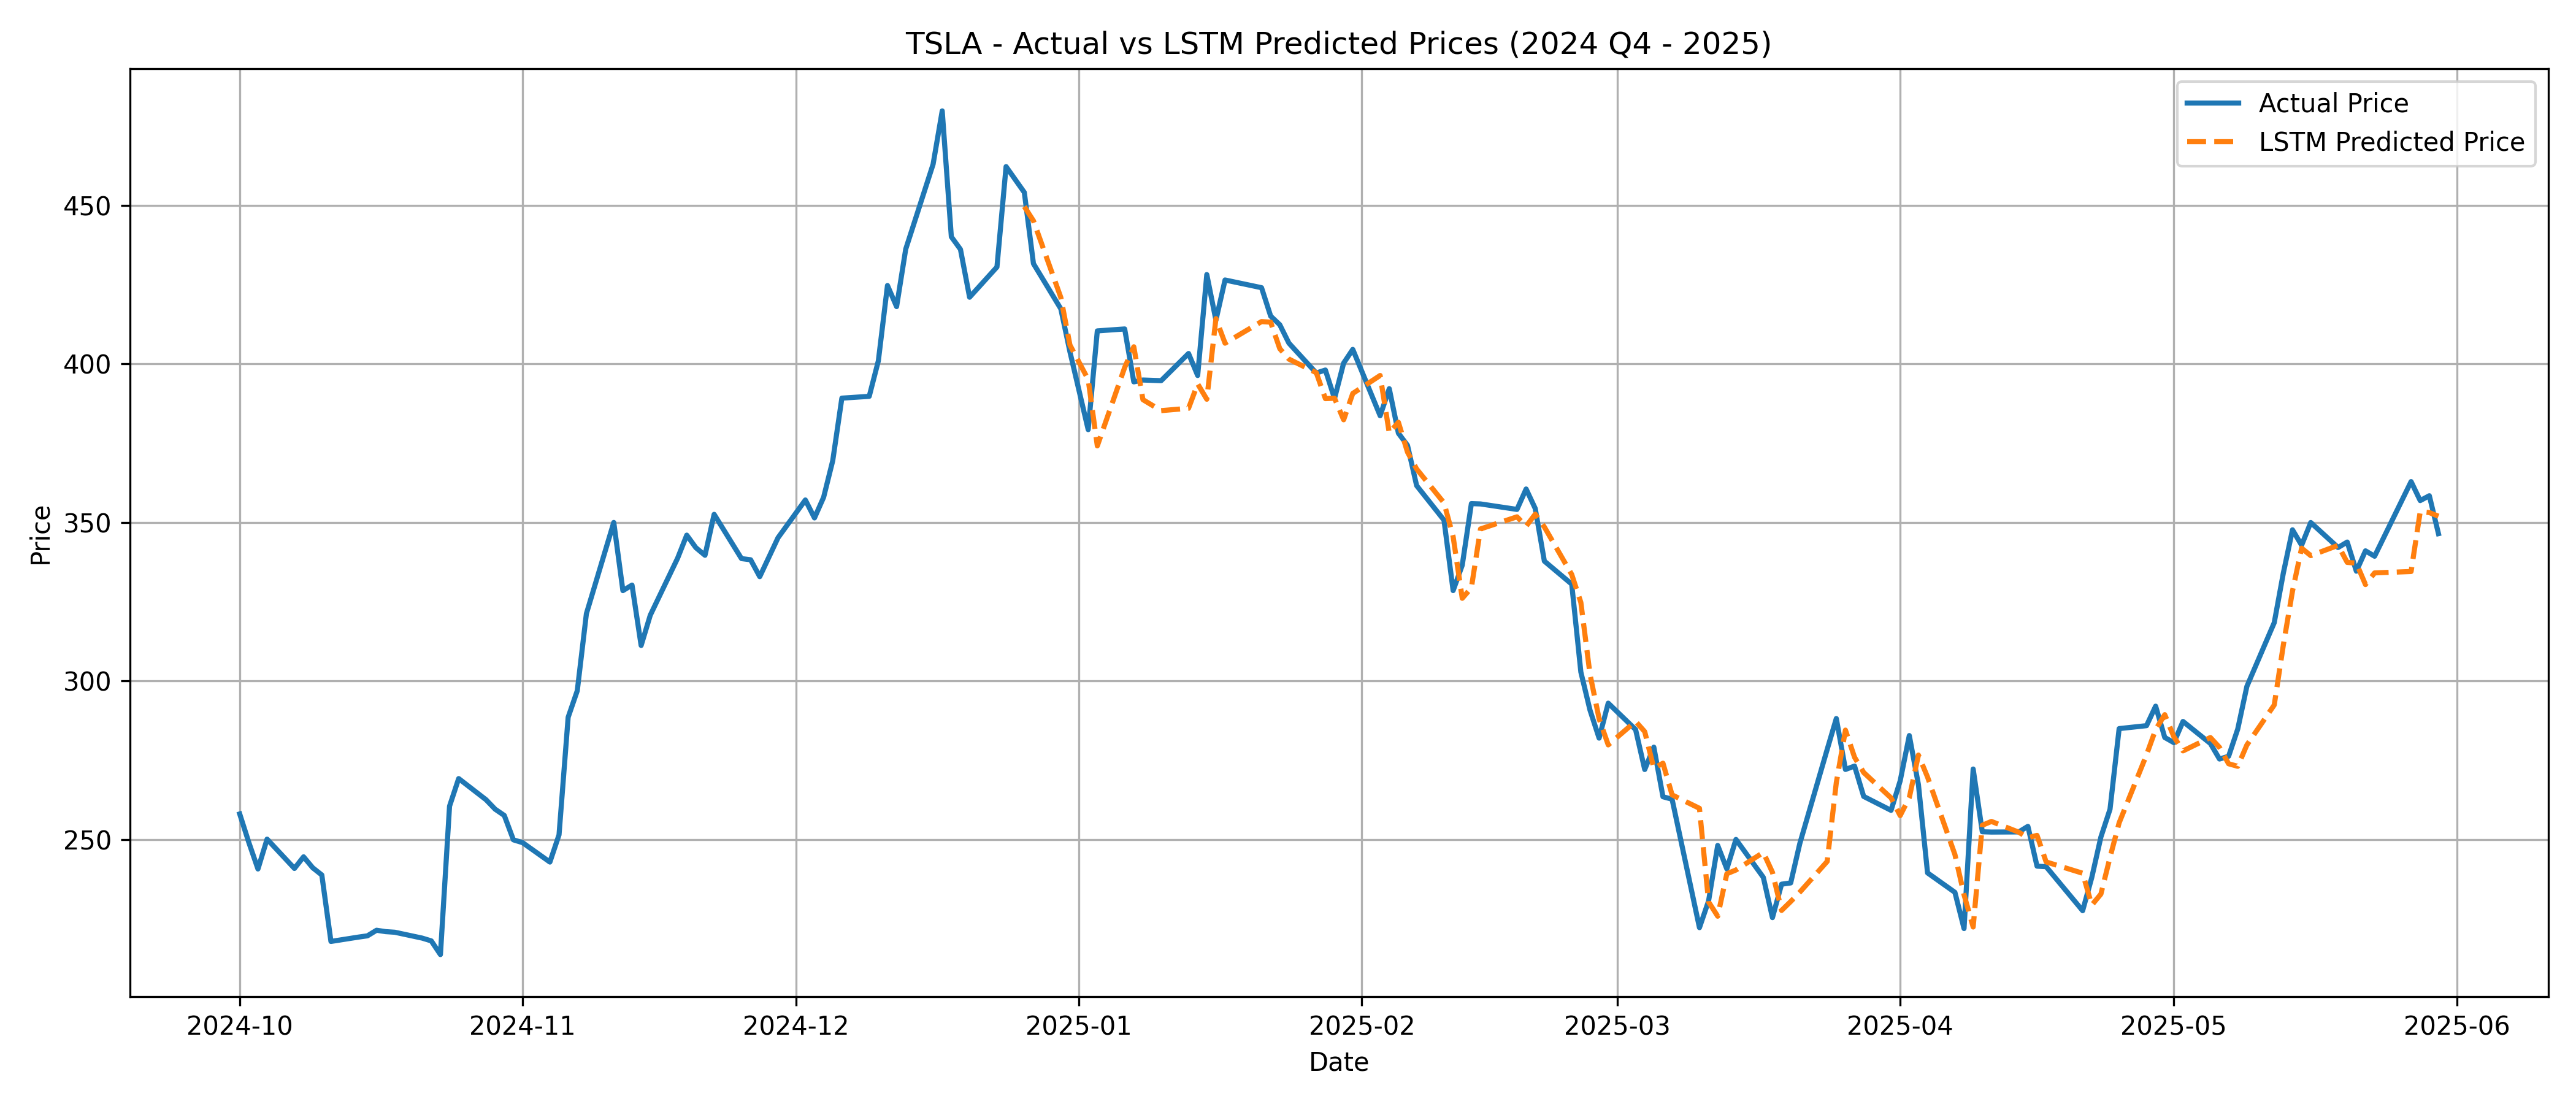

Displaying VOW3.DE_lstm_prediction.png


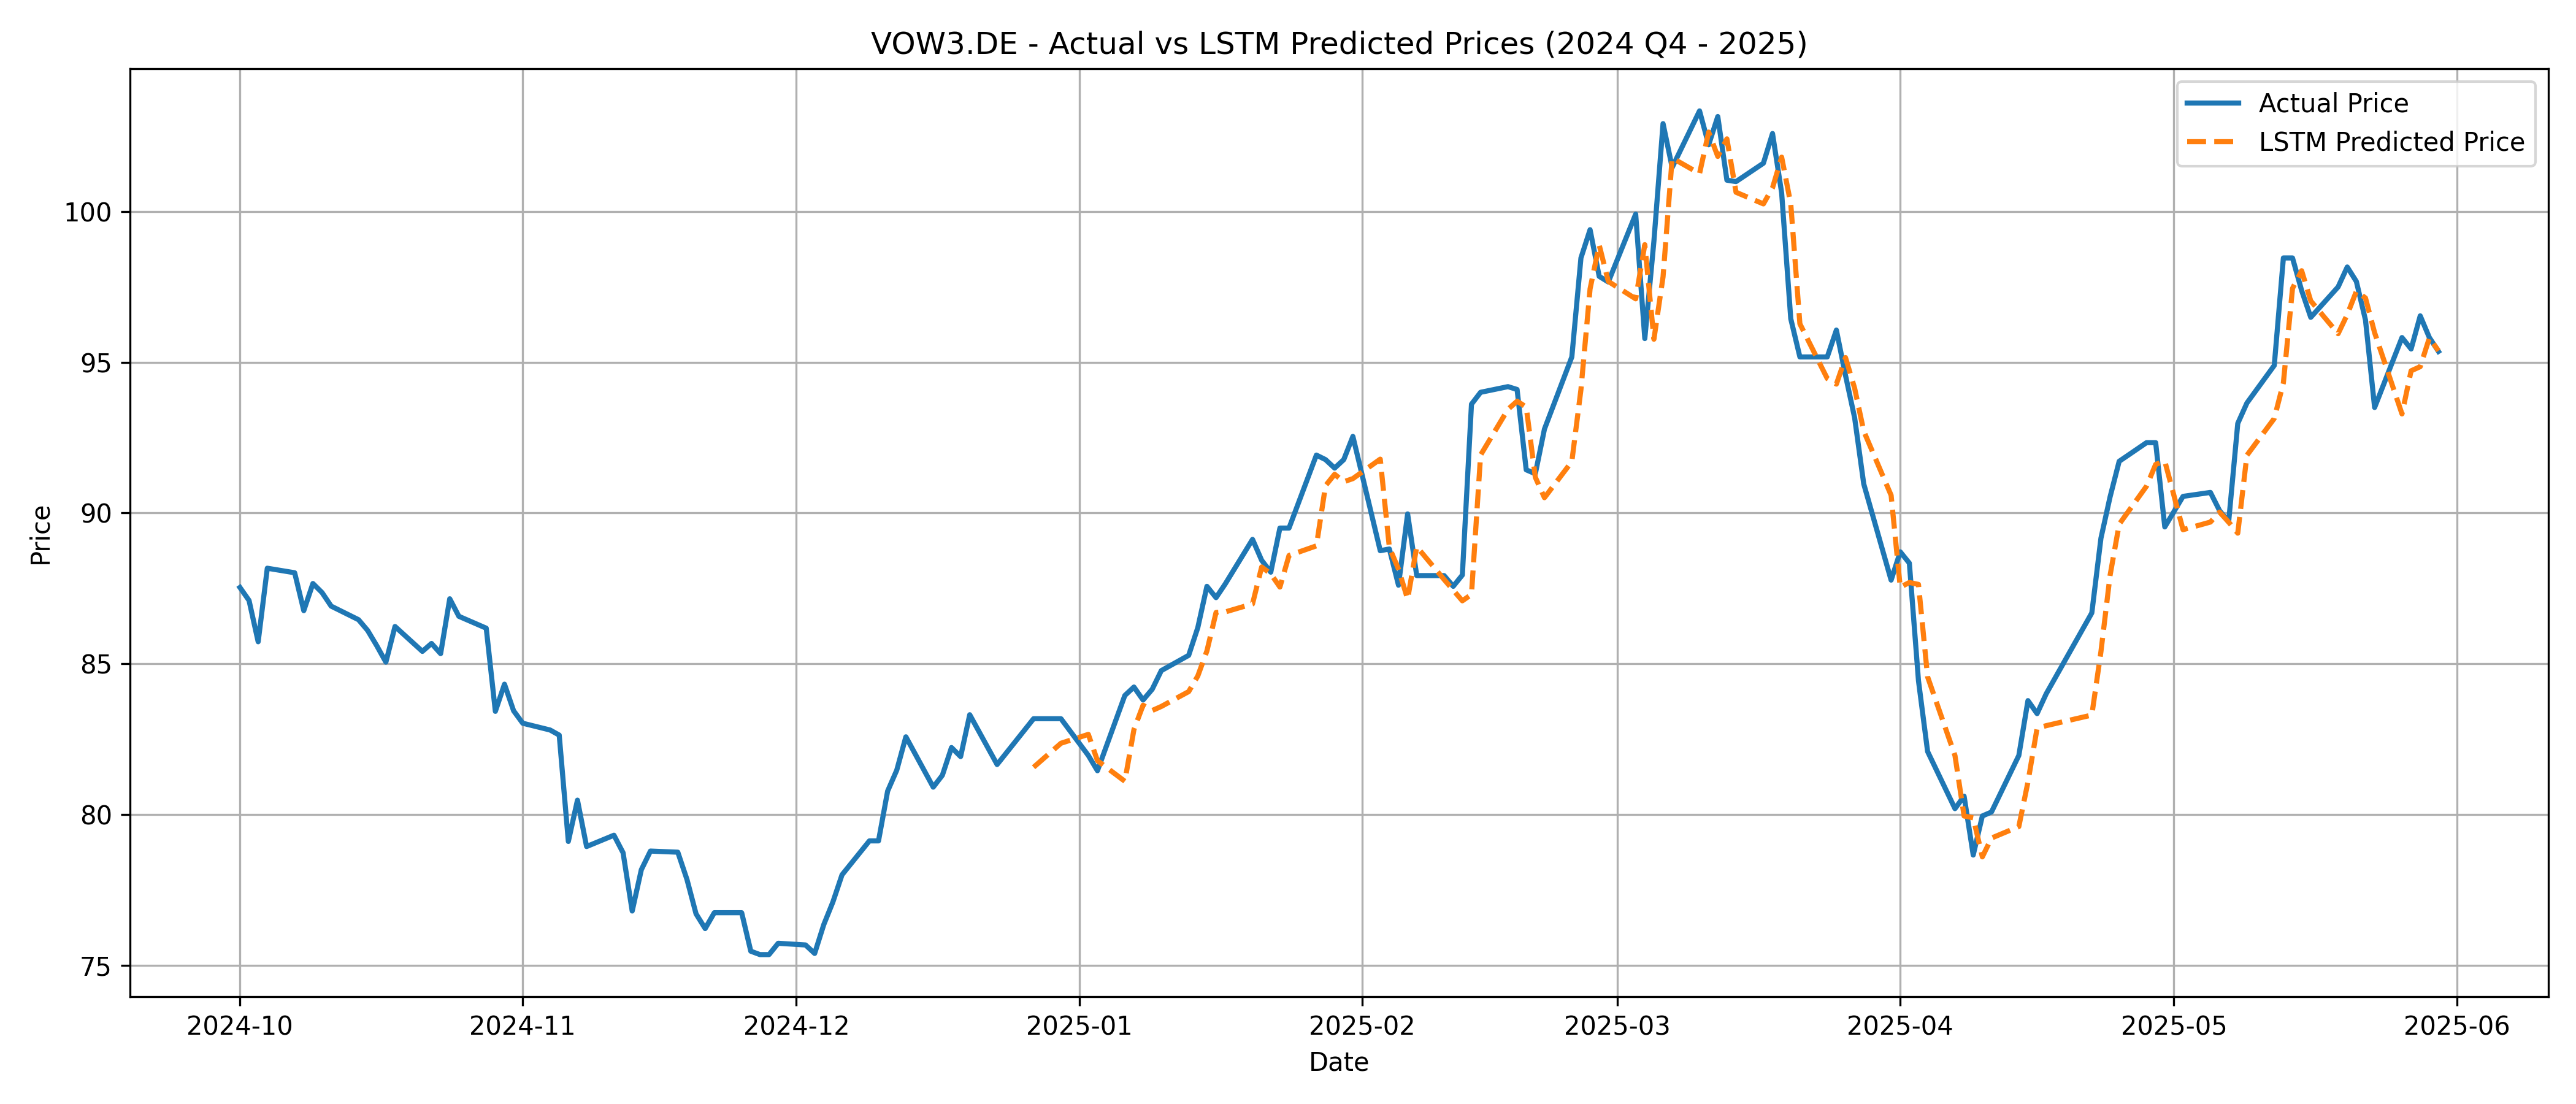

Displaying V_lstm_prediction.png


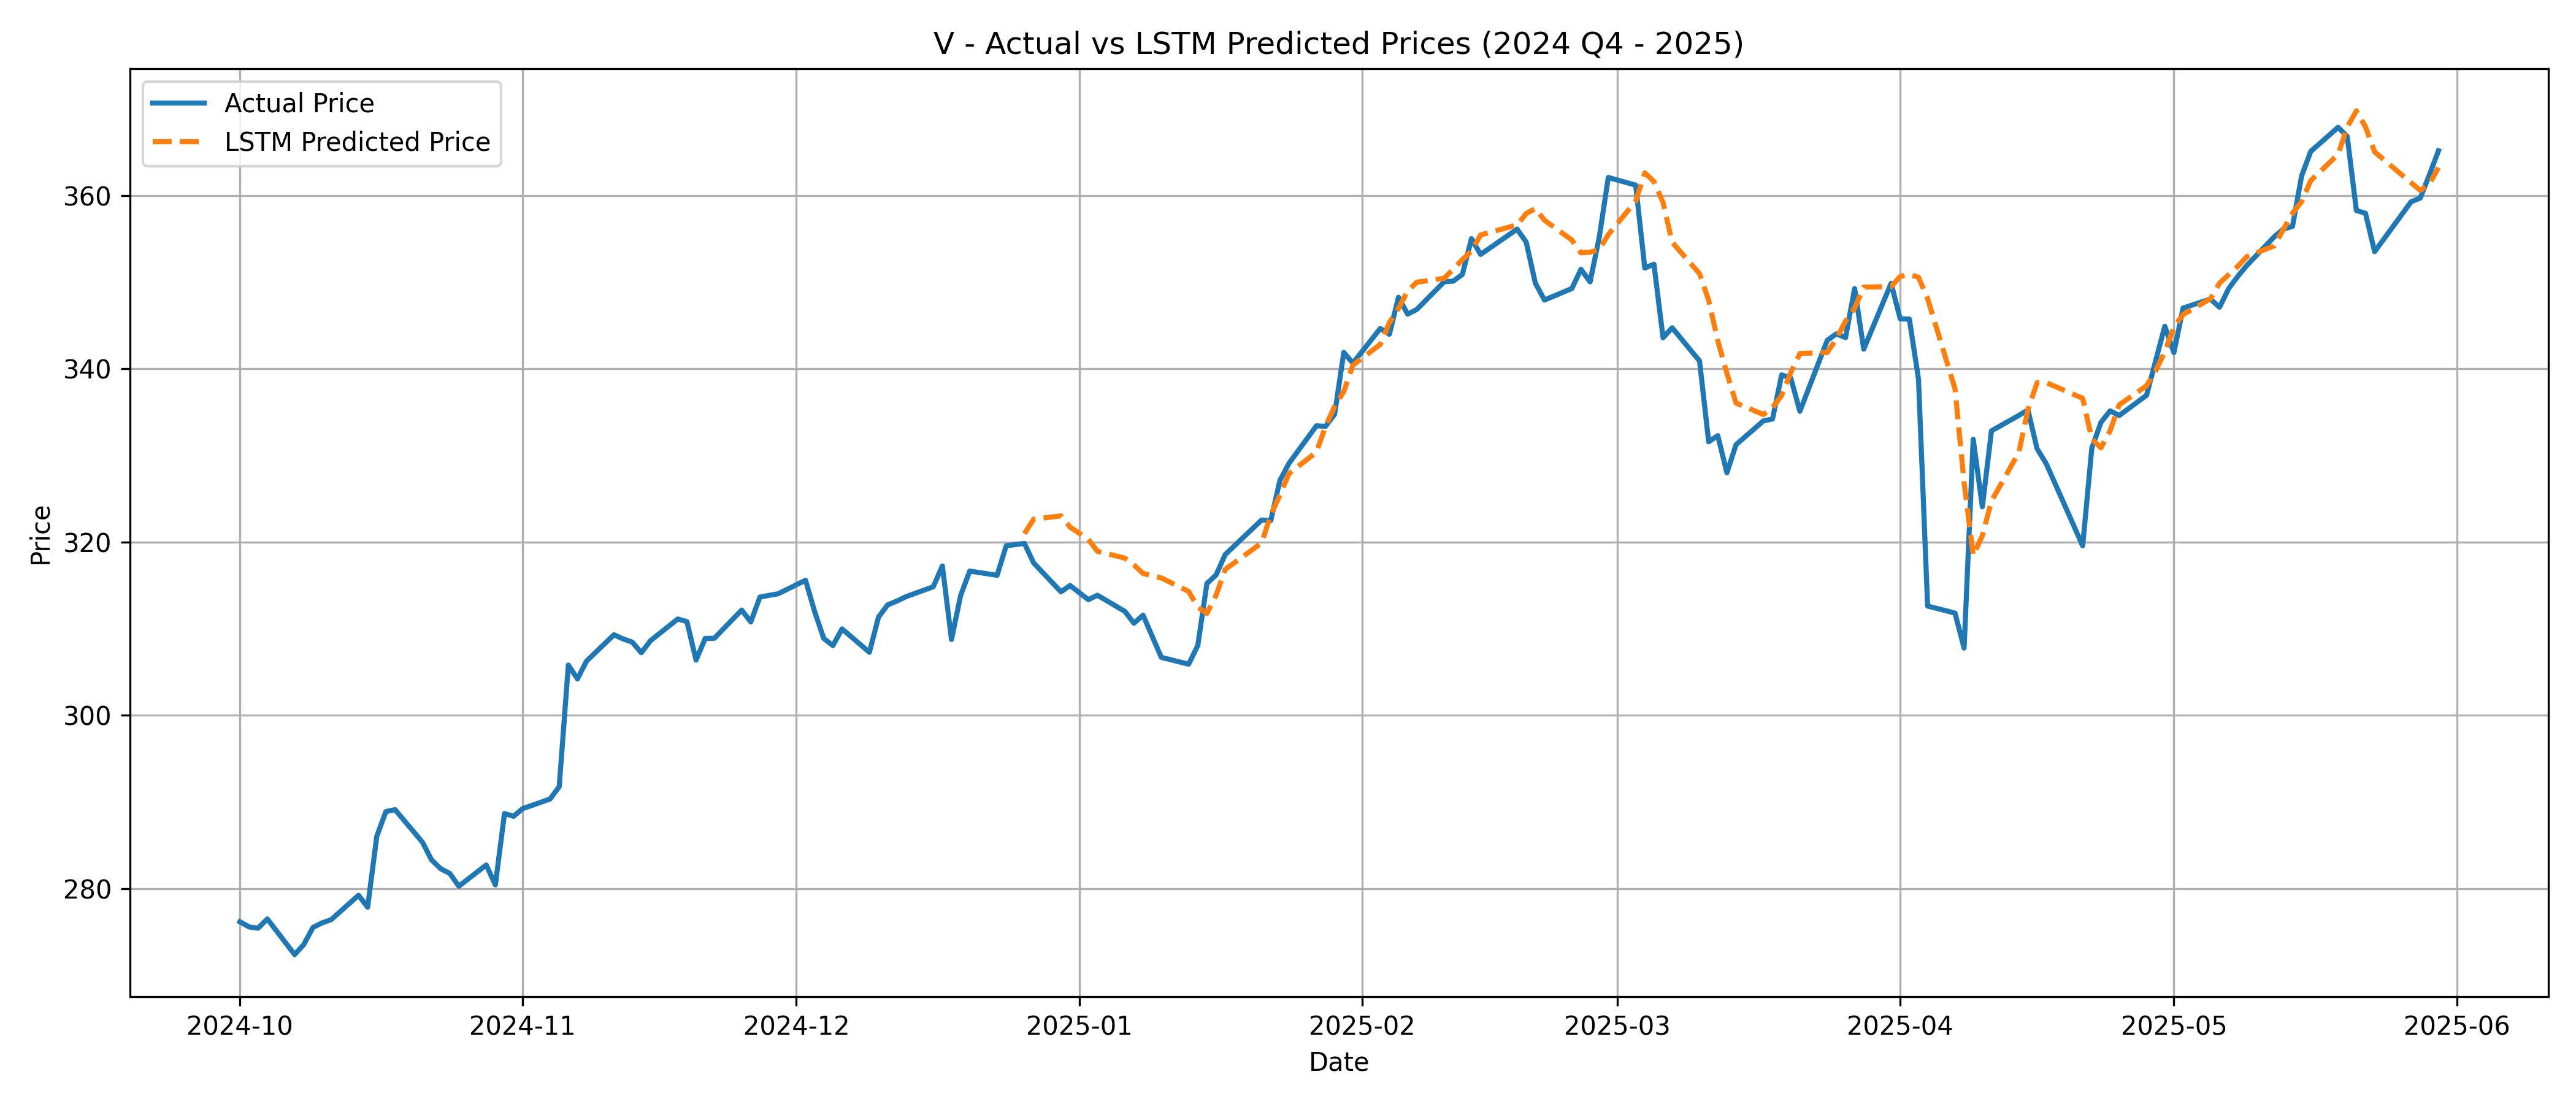

In [2]:
from IPython.display import Image, display
import os

# List of saved chart filenames
chart_files = [
    "AAPL_lstm_prediction.png",
    "AIR.PA_lstm_prediction.png",
    "ALV.DE_lstm_prediction.png",
    "AMZN_lstm_prediction.png",
    "ASML.AS_lstm_prediction.png",
    "BRK-B_lstm_prediction.png",
    "GOOGL_lstm_prediction.png",
    "JPM_lstm_prediction.png",
    "LIN.DE_lstm_prediction.png",
    "MC.PA_lstm_prediction.png",
    "META_lstm_prediction.png",
    "MSFT_lstm_prediction.png",
    "NESN.SW_lstm_prediction.png",
    "NVDA_lstm_prediction.png",
    "OR.PA_lstm_prediction.png",
    "SAP.DE_lstm_prediction.png",
    "SIE.DE_lstm_prediction.png",
    "TSLA_lstm_prediction.png",
    "VOW3.DE_lstm_prediction.png",
    "V_lstm_prediction.png"
]

# Display each chart
for chart_file in chart_files:
    if os.path.exists(chart_file):
        print(f"Displaying {chart_file}")
        display(Image(filename=chart_file))
    else:
        print(f"{chart_file} not found.")


In [3]:
from sklearn.metrics import mean_absolute_error

mae_metrics = {}

print("\nCalculating MAE for each stock...")

for ticker, result in all_predictions.items():
    if result is None or result['Predicted'] is None:
        print(f"{ticker}: MAE calculation skipped due to missing prediction.")
        mae_metrics[ticker] = {'MAE': float('inf')}
        continue

    actual = result['Actual']
    predicted = result['Predicted']

    # Align actual and predicted data
    actual_aligned = actual.loc[predicted.index]
    predicted_aligned = predicted

    if actual_aligned.empty or predicted_aligned.empty:
        print(f"{ticker}: Insufficient aligned data for MAE calculation.")
        mae_metrics[ticker] = {'MAE': float('inf')}
        continue

    try:
        mae = mean_absolute_error(actual_aligned, predicted_aligned)
        mae_metrics[ticker] = {'MAE': mae}
        print(f"{ticker}: LSTM MAE = {mae:.2f}")
    except Exception as e:
        print(f"{ticker}: Error calculating MAE: {e}")
        mae_metrics[ticker] = {'MAE': float('inf')}

print("\n--- MAE Calculation Complete ---")



Calculating MAE for each stock...
AAPL: LSTM MAE = 10.80
AIR.PA: LSTM MAE = 5.23
ALV.DE: LSTM MAE = 4.99
AMZN: LSTM MAE = 5.01
ASML.AS: LSTM MAE = 18.52
BRK-B: LSTM MAE = 24.51
GOOGL: LSTM MAE = 3.58
JPM: LSTM MAE = 6.41
LIN.DE: LSTM MAE = 4.74
MC.PA: LSTM MAE = 13.84
META: LSTM MAE = 16.26
MSFT: LSTM MAE = 8.07
NESN.SW: LSTM MAE = 1.10
NVDA: LSTM MAE = 3.92
OR.PA: LSTM MAE = 6.15
SAP.DE: LSTM MAE = 8.07
SIE.DE: LSTM MAE = 10.79
TSLA: LSTM MAE = 10.88
VOW3.DE: LSTM MAE = 1.53
V: LSTM MAE = 4.92

--- MAE Calculation Complete ---
